# Import Libraries


In [1]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
import pickle
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve,accuracy_score, precision_score, recall_score, f1_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random

2025-05-06 21:23:29.958947: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 21:23:30.311729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746541410.438253     979 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746541410.478817     979 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746541410.799121     979 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Load Essay Dataset

In [2]:
stdset = pd.read_excel("datasets/esai_siswa_24_25.xlsx")
gptset = pd.read_csv("datasets/esai_gpt_24_25.csv")

In [3]:
stdset.info()
stdset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   teks_esai     327 non-null    object
 1   nama          327 non-null    object
 2   asal_sekolah  327 non-null    object
 3   tahun         327 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.3+ KB


,teks_esai,nama,asal_sekolah,tahun
0,P3KTAS: Menciptakan Persatuan dalam Masyarakat...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
1,Apakah Anda memiliki teman atau saudara yang b...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
2,Dengan adanya perbedaan budaya tersebut banyak...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
3,Kasus diskriminasi terbesar di Indonesia lainn...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024
4,Diskriminasi merupakan salah satu faktor yang ...,Achmad Muchasan Nafi,SMA PRIBADI BANDUNG,2024


In [4]:
gptset.info()
gptset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Response  325 non-null    object
dtypes: object(1)
memory usage: 2.7+ KB


,Response
0,judul: merajut harmoni di tengah keberagaman: ...
1,keberagaman merupakan sebuah anugerah yang tid...
2,indonesia dikenal sebagai negeri dengan ribuan...
3,pendidikan multikultural harus menjadi bagian ...
4,"selain pendidikan formal, sosialisasi di komun..."


In [5]:
def preprocess_text(text):
    """
    Preprocessing text:
    - Convert text to lowercase
    - Cleaning up excess whitespace
    - Keeps the text as a whole paragraph
    
    Args:
        text (str): input text.
        
    Returns:
        str: the processed text or None if invalid.
    """
    if not isinstance(text, str) or text.strip() == "":
        return None
    
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('_x000d_', '')
    return text

# Essay Informations

In [6]:
# Count number of texts per author
author_counts = stdset.groupby('nama')['teks_esai'].count().sort_values(ascending=False)
author_counts.index = author_counts.index.map(lambda name: ' '.join([word[:2] + '*' * (len(word) - 2) for word in name.split()]))
total_authors = len(author_counts)

# Count sentences in each text
def count_sentences(text):
    if not isinstance(text, str):
        return 0
    # Clean text first using existing preprocess_text function
    text = preprocess_text(text)
    if not text:
        return 0
    # Split by common sentence endings
    sentences = re.split('[.!?]+', text)
    # Remove empty strings
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

# Apply sentence counting to teks_esai
sentence_counts = stdset['teks_esai'].apply(count_sentences)

# Calculate statistics
single_sentence = sum(sentence_counts == 1)
multiple_sentences = sum(sentence_counts > 1)
total_texts = len(sentence_counts)

# Create a DataFrame to show statistics per author
author_stats = pd.DataFrame()
author_stats['nama'] = author_counts.index
author_stats['single_sentence'] = [sum(sentence_counts[stdset['nama'] == author] == 1) for author in author_stats['nama']]
author_stats['multiple_sentences'] = [sum(sentence_counts[stdset['nama'] == author] > 1) for author in author_stats['nama']]
author_stats['total_texts'] = author_counts.values

# Display the table
print("Statistics per Author:")
print(author_stats.to_string(index=False))

# Calculate and display summary statistics
print("\nStudent Summary:")
print(f"Total authors: {total_authors}")
print(f"Total texts: {total_texts}")
print(f"Total single sentences: {single_sentence}")
print(f"Total multiple sentences: {multiple_sentences}")
print(f"Minimum multiple sentences per author: {author_stats['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats['multiple_sentences'].max()}")
mean_multiple_sentences = author_stats['multiple_sentences'].mean()
print(f"Mean multiple sentences per author: {mean_multiple_sentences:.2f}")


Statistics per Author:
                                           nama  single_sentence  multiple_sentences  total_texts
                     Sy********* Mu****** Wa***                0                   0           30
                       Na**** Na****** La******                0                   0           20
                               Ar** Nu*********                0                   0           20
                        Na*** Iz**** Fi********                0                   0           20
                                De** Ty** Ut***                0                   0           19
                                   Le** Li*****                0                   0           19
                                 Sh***** Ta****                0                   0           17
                      Se*** An***** Wi*********                0                   0           17
                             Be*** Aq*** Ir****                0                   0           

In [7]:
# Create subsets based on year
author_stats_2024 = author_stats[author_stats['nama'].isin(stdset[stdset['tahun'] == 2024]['nama'].unique())]
author_stats_2025 = author_stats[author_stats['nama'].isin(stdset[stdset['tahun'] == 2025]['nama'].unique())]

# Print statistics for 2024
print("\nStatistics for 2024:")
print(f"Total authors: {len(author_stats_2024)}")
print(f"Total texts: {author_stats_2024['total_texts'].sum()}")
print(f"Total single sentences: {author_stats_2024['single_sentence'].sum()}")
print(f"Total multiple sentences: {author_stats_2024['multiple_sentences'].sum()}")
print(f"Minimum multiple sentences per author: {author_stats_2024['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats_2024['multiple_sentences'].max()}")
print(f"Mean multiple sentences per author: {author_stats_2024['multiple_sentences'].mean():.2f}")

# Print statistics for 2025  
print("\nStatistics for 2025:")
print(f"Total authors: {len(author_stats_2025)}")
print(f"Total texts: {author_stats_2025['total_texts'].sum()}")
print(f"Total single sentences: {author_stats_2025['single_sentence'].sum()}")
print(f"Total multiple sentences: {author_stats_2025['multiple_sentences'].sum()}")
print(f"Minimum multiple sentences per author: {author_stats_2025['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats_2025['multiple_sentences'].max()}")
print(f"Mean multiple sentences per author: {author_stats_2025['multiple_sentences'].mean():.2f}")



Statistics for 2024:
Total authors: 0
Total texts: 0
Total single sentences: 0
Total multiple sentences: 0
Minimum multiple sentences per author: nan
Maximum multiple sentences per author: nan
Mean multiple sentences per author: nan

Statistics for 2025:
Total authors: 0
Total texts: 0
Total single sentences: 0
Total multiple sentences: 0
Minimum multiple sentences per author: nan
Maximum multiple sentences per author: nan
Mean multiple sentences per author: nan


In [8]:
sentence_counts = gptset['Response'].apply(count_sentences)

# Calculate statistics
single_sentence = sum(sentence_counts == 1)
multiple_sentences = sum(sentence_counts > 1)
total_texts = len(sentence_counts)

print("\nChatGPT Summary:")
print(f"Total texts: {total_texts}")
print(f"Total single sentences: {single_sentence}")
print(f"Total multiple sentences: {multiple_sentences}")
print(f"Minimum multiple sentences per author: {author_stats['multiple_sentences'].min()}")
print(f"Maximum multiple sentences per author: {author_stats['multiple_sentences'].max()}")
mean_multiple_sentences = author_stats['multiple_sentences'].mean()
print(f"Mean multiple sentences per author: {mean_multiple_sentences:.2f}")


ChatGPT Summary:
Total texts: 325
Total single sentences: 20
Total multiple sentences: 305
Minimum multiple sentences per author: 0
Maximum multiple sentences per author: 0
Mean multiple sentences per author: 0.00


# Load Dataset for Training

In [9]:
#load dataset
std_txt = []
gpt_txt = []

# Process Student essay
for text in stdset['teks_esai']:
    processed = preprocess_text(text)
    if processed:
        std_txt.append(processed)

# Process ChatGPT essay
for text in gptset['Response']:
    processed = preprocess_text(text)
    if processed:
        gpt_txt.append(processed)

texts = std_txt + gpt_txt
labels = [0] * len(std_txt) + [1] * len(gpt_txt)
names = []
for name in stdset['nama'].tolist():
    censored_name = ' '.join([word[:2] + '*' * (len(word) - 2) for word in name.split()])
    names.append(censored_name)
    
names = names + ['ChatGPT'] * len(gpt_txt)
data = pd.DataFrame({'text': texts, 'label': labels, 'name': names})

# Show total number of processed texts
print(f"Total student text: {len(std_txt)}")
print(f"Total ChatGPT text: {len(gpt_txt)}")
print(f"Total texts: {len(texts)}")

print(data.head(5))
print(data.sample(5))


Total student text: 327
Total ChatGPT text: 325
Total texts: 652
                                                text  label  \
0  p3ktas: menciptakan persatuan dalam masyarakat...      0   
1  apakah anda memiliki teman atau saudara yang b...      0   
2  dengan adanya perbedaan budaya tersebut banyak...      0   
3  kasus diskriminasi terbesar di indonesia lainn...      0   
4  diskriminasi merupakan salah satu faktor yang ...      0   

                   name  
0  Ac**** Mu****** Na**  
1  Ac**** Mu****** Na**  
2  Ac**** Mu****** Na**  
3  Ac**** Mu****** Na**  
4  Ac**** Mu****** Na**  
                                                  text  label  \
419  tentu tidak lupa peran individu dalam menjaga ...      1   
191  setelah berhasil mengasah keterampilan di bida...      0   
543  dalam mengolah hidup, kita belajar untuk melak...      1   
374  sebagai siswa sma yang hidup dalam masyarakat ...      1   
369  dampak dari manajemen keberagaman yang baik ti...      1   

         

# Data Splitting
- Training 75%
- Validation 5%
- Testing 20%

In [10]:
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['label']
)

print(f"Initial training set: {len(train_data)} samples")
print(f"Initial test set: {len(test_data)} samples")
print(f"Initial training distribution: Student={sum(train_data['label']==0)}, ChatGPT={sum(train_data['label']==1)}")
print(f"Initial test distribution: Student={sum(test_data['label']==0)}, ChatGPT={sum(test_data['label']==1)}")


X_train = train_data[['text']]
y_train = train_data['label']

undersampler = RandomUnderSampler(random_state=42)
X_train_indices = pd.DataFrame({'index': range(len(X_train))})
X_resampled_indices, y_resampled = undersampler.fit_resample(X_train_indices, y_train)

selected_indices = X_resampled_indices['index'].values

balanced_train_data = train_data.iloc[selected_indices].reset_index(drop=True)

removed_indices = set(range(len(train_data))) - set(selected_indices)
removed_samples = train_data.iloc[list(removed_indices)]

test_set = pd.concat([test_data, removed_samples]).reset_index(drop=True)
test_set = test_set.sort_values(by='label').reset_index(drop=True)

train_set, val_set = train_test_split(
    balanced_train_data, test_size=5/80, random_state=42, stratify=balanced_train_data['label']
)

train_set = train_set.sort_values(by='label').reset_index(drop=True)
val_set = val_set.sort_values(by='label').reset_index(drop=True)

# Print final dataset statistics
print("\nAfter undersampling:")
print(f"Training set: {len(train_set)} samples (Student={sum(train_set['label']==0)}, ChatGPT={sum(train_set['label']==1)})")
print(f"Validation set: {len(val_set)} samples (Student={sum(val_set['label']==0)}, ChatGPT={sum(val_set['label']==1)})")
print(f"Test set: {len(test_set)} samples (Student={sum(test_set['label']==0)}, ChatGPT={sum(test_set['label']==1)})")


Initial training set: 521 samples
Initial test set: 131 samples
Initial training distribution: Student=261, ChatGPT=260
Initial test distribution: Student=66, ChatGPT=65

After undersampling:
Training set: 487 samples (Student=243, ChatGPT=244)
Validation set: 33 samples (Student=17, ChatGPT=16)
Test set: 132 samples (Student=67, ChatGPT=65)


# Initialize BERT Tokenizer

In [11]:
# Initialize IndoBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Tokenize function
def tokenize_text(texts, max_length=256):
    """
    Text tokenization using IndoBERT tokenizer.
    
    Args:
        texts (list): List of texts to be tokenized.
        max_length (int): Maximum token length.
        
    Returns:
        dict: Tokenized result, including input_ids and attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [12]:
# Tokenize student and ChatGPT essays
print("Tokenize student essay...")
std_tokens = tokenize_text(std_txt)
print("Tokenize ChatGPT essay...")
gpt_tokens = tokenize_text(gpt_txt)

print("Tokenize student essay (Training Set)...")
std_tr_tokens = tokenize_text(train_set[train_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Training Set)...")
gpt_tr_tokens = tokenize_text(train_set[train_set['label'] == 1]['text'].tolist())

print("Tokenize student essay (Validation Set)...")
std_va_tokens = tokenize_text(val_set[val_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Validation Set)...")
gpt_va_tokens = tokenize_text(val_set[val_set['label'] == 1]['text'].tolist())

print("Tokenize student essay (Test Set)...")
std_te_tokens = tokenize_text(test_set[test_set['label'] == 0]['text'].tolist())
print("Tokenize ChatGPT essay (Test Set)...")
gpt_te_tokens = tokenize_text(test_set[test_set['label'] == 1]['text'].tolist())

# Display tokenization results (example: Student)
print("\nExample of tokenization results:")
print(std_tr_tokens['input_ids'][:3])  # Input token ID
print(std_tr_tokens['attention_mask'][:3])  # Attention mask

Tokenize student essay...


I0000 00:00:1746541418.655367     979 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5529 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Tokenize ChatGPT essay...
Tokenize student essay (Training Set)...
Tokenize ChatGPT essay (Training Set)...
Tokenize student essay (Validation Set)...
Tokenize ChatGPT essay (Validation Set)...
Tokenize student essay (Test Set)...
Tokenize ChatGPT essay (Test Set)...

Example of tokenization results:
AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
tf.Tensor(
[[    2 30063  1652   154  4710  1092  2812 14058   628 14359  1191  3492
    112   282 13051  3343 30470 30063  1652   234  5300   300 30468  3543
     34   659  1210  2970  1350   245   501  1175  1403    34   219  9444
     26 22031  2506 30470  4061   452  3331  4947 15012   242 26412   664
    234 19483  1876    98  1175 30063  1652 30470  7694    98 26412   256
    154  5506   112  2217    34  3508 22870   242  2697 10719 30470   370
     98   137 30468  8718  1175 30469  1175   256   735   477 24997   647
    579   552     1  2372  3500  1734     1  7919   669 19111    79 11364
   6482  9374  3492 30470  

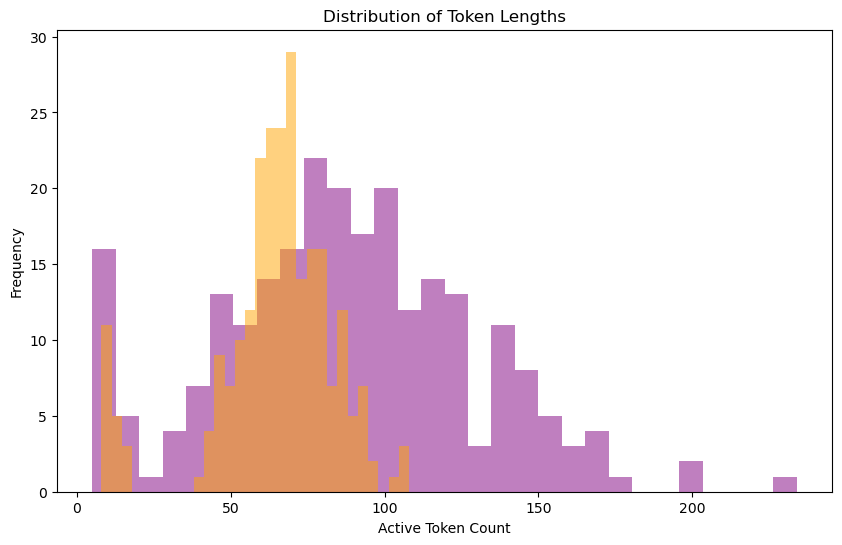

Average token length for Student: 87.06
Percentage truncated for Student: 0.00%
Average token length for ChatGPT: 64.13
Percentage truncated for ChatGPT: 0.00%


In [13]:
std_tr_lengths = [sum(mask) for mask in std_tr_tokens['attention_mask'].numpy()]
gpt_tr_lengths = [sum(mask) for mask in gpt_tr_tokens['attention_mask'].numpy()]

plt.figure(figsize=(10, 6))
plt.hist(std_tr_lengths, bins=30, alpha=0.5, label='Student', color='purple')
plt.hist(gpt_tr_lengths, bins=30, alpha=0.5, label='ChatGPT', color='orange')
plt.title('Distribution of Token Lengths')
plt.xlabel('Active Token Count')
plt.ylabel('Frequency')
plt.show()
print(f"Average token length for Student: {np.mean(std_tr_lengths):.2f}")
print(f"Percentage truncated for Student: {sum(l == 256 for l in std_tr_lengths) / len(std_tr_lengths) * 100:.2f}%")
print(f"Average token length for ChatGPT: {np.mean(gpt_tr_lengths):.2f}")
print(f"Percentage truncated for ChatGPT: {sum(l == 256 for l in gpt_tr_lengths) / len(gpt_tr_lengths) * 100:.2f}%")

In [14]:
# Decoding tokens for ensuring correctness
sample_text = gpt_txt[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Sample Text: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

Sample Text: judul: merajut harmoni di tengah keberagaman: kunci kejayaan masyarakat multikultural
Token ID: [2, 3011, 30472, 17802, 4882, 30358, 20596, 26, 1172, 21585, 30472, 2697, 16071, 552, 30063, 3]
Token dekode: [CLS] judul : merajut harmoni di tengah keberagaman : kunci kejayaan masyarakat multikultural [SEP]


In [15]:
# Save tokenized data
tokenized_data = {
    'student': std_tokens,
    'chatgpt': gpt_tokens
}

# Save input_ids and attention_mask as numpy arrays
tokenized_numpy = {
    'student': {
        'input_ids': std_tokens['input_ids'].numpy(),
        'attention_mask': std_tokens['attention_mask'].numpy()
    },
    'chatgpt ': {
        'input_ids': gpt_tokens ['input_ids'].numpy(),
        'attention_mask': gpt_tokens ['attention_mask'].numpy()
    }
}

os.makedirs("paper", exist_ok=True)

with open('paper/tokenized_data.pkl', 'wb') as f:
    pickle.dump(tokenized_numpy, f)

# Build IndoBERT Semantic Similarity Model

In [16]:
# Load IndoBERT model
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Define Bi-Encoder model
def model(bert_model):
    """
    Create a Bi-Encoder model with IndoBERT.
    
    Args:
        bert_model (TFBertModel): Base model of IndoBERT.
        
    Returns:
        tf.keras.Model: Bi-Encoder model.
    """
    # Input layer
    input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="attention_mask")
    
    # Extract CLS token embeddings from IndoBERT
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]  # [CLS] token
    
    # Dense layer for fine-tuning
    dense1 = tf.keras.layers.Dense(256, activation="relu")(bert_output)
    dropout1 = tf.keras.layers.Dropout(0.1)(dense1)
    dense2 = tf.keras.layers.Dense(256, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.1)(dense2)
    dense3 = tf.keras.layers.Dense(256)(dropout2)
    
    # Output normalization (L2 normalization)
    normalized_output = tf.nn.l2_normalize(dense3, axis=1)
    
    # Semantic model
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=normalized_output)

# Build model
semantic_model = model(bert_model)

# Show model summary
print("Model Summary:")
semantic_model.summary()


Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                        

# Create Contrastive Pairs

In [17]:
def create_contrastive_pairs(student_tokens, chatgpt_tokens, max_pairs=None):
    """
    Creates data pairs for contrastive learning with dataset-appropriate quantities.

    Args:
        student_tokens: Tokenized student text
        chatgpt_tokens_1: First set of tokenized ChatGPT text
        chatgpt_tokens_2: Second set of tokenized ChatGPT text
        max_pairs: Maximum number of pairs (optional). If None, uses all possible combinations.

    Returns:
        tuple: Dictionary of anchor, positive, negative pairs and labels, and the total number of pairs.
    """
    # Get dataset sizes
    n_student = student_tokens['input_ids'].shape[0]
    n_chatgpt = chatgpt_tokens['input_ids'].shape[0]
    
    # Calculate maximum possible combinations
    max_student_pairs = (n_student * (n_student - 1)) // 2  # student-student combinations
    max_chatgpt_pairs = (n_chatgpt * (n_chatgpt - 1)) // 2  # chatgpt-chatgpt combinations
    max_negative_pairs = n_student * n_chatgpt  # student-chatgpt combinations
    
    # Determine number of pairs to create
    if max_pairs is None:
        # Use minimum number of positive pairs for balance
        n_pos_student = min(max_student_pairs, max_chatgpt_pairs) // 2
        n_pos_chatgpt = n_pos_student
        # Limit negative pairs to balance with positives
        n_neg_pairs = min(max_negative_pairs, 2 * n_pos_student)
    else:
        # If max_pairs is specified, use that with equal proportions
        n_pos_student = max_pairs // 4
        n_pos_chatgpt = max_pairs // 4
        n_neg_pairs = max_pairs // 2
    
    # Ensure we don't exceed the maximum possible combinations
    n_pos_student = min(n_pos_student, max_student_pairs)
    n_pos_chatgpt = min(n_pos_chatgpt, max_chatgpt_pairs)
    n_neg_pairs = min(n_neg_pairs, max_negative_pairs)
    
    # Initialize arrays for data pairs
    anchor_input_ids = []
    anchor_attention_mask = []
    positive_input_ids = []
    positive_attention_mask = []
    negative_input_ids = []
    negative_attention_mask = []
    labels = []
    
    # Generate positive student-student pairs
    if n_pos_student > 0:
        # Create all possible student-student pairs
        student_pairs = [(i, j) for i in range(n_student) for j in range(i+1, n_student)]
        # Randomly select pairs
        selected_pairs = random.sample(student_pairs, n_pos_student)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (student)
            anchor_input_ids.append(student_tokens['input_ids'][idx1])
            anchor_attention_mask.append(student_tokens['attention_mask'][idx1])
            
            # Positive (another student)
            positive_input_ids.append(student_tokens['input_ids'][idx2])
            positive_attention_mask.append(student_tokens['attention_mask'][idx2])
            
            # Negative (from ChatGPT)
            neg_idx = np.random.choice(n_chatgpt)
            negative_input_ids.append(chatgpt_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate positive chatgpt-chatgpt pairs
    if n_pos_chatgpt > 0:
        # Create all possible chatgpt-chatgpt pairs
        chatgpt_pairs = [(i, j) for i in range(n_chatgpt) for j in range(i+1, n_chatgpt)]
        # Randomly select pairs
        selected_pairs = random.sample(chatgpt_pairs, n_pos_chatgpt)
        
        for idx1, idx2 in selected_pairs:
            # Anchor
            anchor_input_ids.append(chatgpt_tokens['input_ids'][idx1])
            anchor_attention_mask.append(chatgpt_tokens['attention_mask'][idx1])
            
            # Positive
            positive_input_ids.append(chatgpt_tokens['input_ids'][idx2])
            positive_attention_mask.append(chatgpt_tokens['attention_mask'][idx2])
            
            # Negative (from Student)
            neg_idx = np.random.choice(n_student)
            negative_input_ids.append(student_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(student_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate negative student-chatgpt pairs
    if n_neg_pairs > 0:
        # Create all possible student-chatgpt pairs
        negative_pairs = [(i, j) for i in range(n_student) for j in range(n_chatgpt)]
        # Randomly select pairs
        selected_pairs = random.sample(negative_pairs, n_neg_pairs)
        
        for student_idx, chatgpt_idx in selected_pairs:
            # Anchor (Student)
            anchor_input_ids.append(student_tokens['input_ids'][student_idx])
            anchor_attention_mask.append(student_tokens['attention_mask'][student_idx])
            
            # Negative (ChatGPT)
            negative_input_ids.append(chatgpt_tokens['input_ids'][chatgpt_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][chatgpt_idx])
            
            # Positive (another Student different from anchor)
            available_pos = [i for i in range(n_student) if i != student_idx]
            if available_pos:  # Ensure there are available indices
                pos_idx = np.random.choice(available_pos)
                positive_input_ids.append(student_tokens['input_ids'][pos_idx])
                positive_attention_mask.append(student_tokens['attention_mask'][pos_idx])
                
                # Label (0 for negative pair)
                labels.append(0)
    
    # Count actual pairs created
    actual_pairs = len(labels)
    
    # Convert to tensors and return
    return {
        'anchor': {
            'input_ids': tf.convert_to_tensor(anchor_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(anchor_attention_mask, dtype=tf.int32)
        },
        'positive': {
            'input_ids': tf.convert_to_tensor(positive_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(positive_attention_mask, dtype=tf.int32)
        },
        'negative': {
            'input_ids': tf.convert_to_tensor(negative_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(negative_attention_mask, dtype=tf.int32)
        },
        'labels': tf.convert_to_tensor(labels, dtype=tf.float32)
    }, actual_pairs

In [18]:
# Create contrastive pairs
std_gpt_tr_pairs, total_pairs_tr = create_contrastive_pairs(std_tr_tokens, gpt_tr_tokens, max_pairs=None)
std_gpt_va_pairs, total_pairs_va = create_contrastive_pairs(std_va_tokens, gpt_va_tokens, max_pairs=None)

# Show the number of pairs created
print(f"Total contrastive pairs (training) created: {total_pairs_tr}")
print(f"- Positive pairs student-student: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Positive pairs chatgpt-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Negative pairs student-chatgpt: {sum(1 for label in std_gpt_tr_pairs['labels'].numpy() if label == 0)}")


Total contrastive pairs (training) created: 58804
- Positive pairs student-student: 14701
- Positive pairs chatgpt-chatgpt: 14701
- Negative pairs student-chatgpt: 29402


# Build Triplet Model

In [19]:
# Model for training with triplet loss
def triplet_model(semantic_model):
    """
    Build a model for training with triplet loss.
    
    Args:
        semantic_model: The semantic similarity model to be trained.
        
    Returns:
         tf.keras.Model: Model for training with triplet loss.
    """
    # Input for anchor, positive, and negative
    anchor_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="anchor_input_ids")
    anchor_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="anchor_attention_mask")
    
    positive_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="positive_input_ids")
    positive_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="positive_attention_mask")
    
    negative_input_ids = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="negative_input_ids")
    negative_attention_mask = tf.keras.layers.Input(shape=(256,), dtype=tf.int32, name="negative_attention_mask")
    
    # Embedding for anchor, positive, and negative
    anchor_embedding = semantic_model([anchor_input_ids, anchor_attention_mask])
    positive_embedding = semantic_model([positive_input_ids, positive_attention_mask])
    negative_embedding = semantic_model([negative_input_ids, negative_attention_mask])
    
    # measure cosine similarity
    pos_similarity = tf.reduce_sum(anchor_embedding * positive_embedding, axis=1)
    neg_similarity = tf.reduce_sum(anchor_embedding * negative_embedding, axis=1)
    
    # Model output is the similarity score
    output = tf.stack([pos_similarity, neg_similarity], axis=1)
    
    return tf.keras.Model(
        inputs=[
            anchor_input_ids, anchor_attention_mask,
            positive_input_ids, positive_attention_mask,
            negative_input_ids, negative_attention_mask
        ],
        outputs=output
    )

# Triplet Loss Function

In [20]:
# Triplet loss function
def triplet_loss(y_true, y_pred):
    """
    Triplet loss: tunes the network such that
the distance between a and p is smaller than the
distance between a and n.
    
    Args:
        y_true: not used triplet loss.
        y_pred: stack of [positive_similarity, negative_similarity].
        
    Returns:
        tf.Tensor: loss value.
    """
    pos_sim = y_pred[:, 0]
    neg_sim = y_pred[:, 1]
    margin = 0.5
    
    # Triplet loss: max(0, margin - (pos_sim - neg_sim))
    loss = tf.maximum(0., margin - (pos_sim - neg_sim))
    return tf.reduce_mean(loss)

# Train IndoBERT Semantic Similarity Model

In [21]:
# Build triplet model for student vs ChatGPT essay
build_triplet = triplet_model(semantic_model)

# Compile model
build_triplet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Student_ChatGPT
print("Training model...")
history = build_triplet.fit(
    x=[
        std_gpt_tr_pairs['anchor']['input_ids'],
        std_gpt_tr_pairs['anchor']['attention_mask'],
        std_gpt_tr_pairs['positive']['input_ids'],
        std_gpt_tr_pairs['positive']['attention_mask'],
        std_gpt_tr_pairs['negative']['input_ids'],
        std_gpt_tr_pairs['negative']['attention_mask']
    ],
    y=std_gpt_tr_pairs['labels'], 
    epochs=10,
    batch_size=16,
    validation_data=(
    [
        std_gpt_va_pairs['anchor']['input_ids'],
        std_gpt_va_pairs['anchor']['attention_mask'],
        std_gpt_va_pairs['positive']['input_ids'],
        std_gpt_va_pairs['positive']['attention_mask'],
        std_gpt_va_pairs['negative']['input_ids'],
        std_gpt_va_pairs['negative']['attention_mask']
    ],
    std_gpt_va_pairs['labels']
    ),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Training model...
Epoch 1/10


I0000 00:00:1746541477.524486    1179 service.cc:152] XLA service 0x7fe1566df100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746541477.524537    1179 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-05-06 21:24:37.546708: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746541477.581611    1179 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746541477.693595    1179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3676/3676 [==============================] - 1659s 447ms/step - loss: 0.1527 - val_loss: 0.0903
Epoch 2/10
3676/3676 [==============================] - 1637s 445ms/step - loss: 0.0290 - val_loss: 0.1040
Epoch 3/10
3676/3676 [==============================] - 1636s 445ms/step - loss: 0.0122 - val_loss: 0.0653
Epoch 4/10
3676/3676 [==============================] - 1635s 445ms/step - loss: 0.0075 - val_loss: 0.1173
Epoch 5/10
3676/3676 [==============================] - 1635s 445ms/step - loss: 0.0048 - val_loss: 0.1548


# Training History

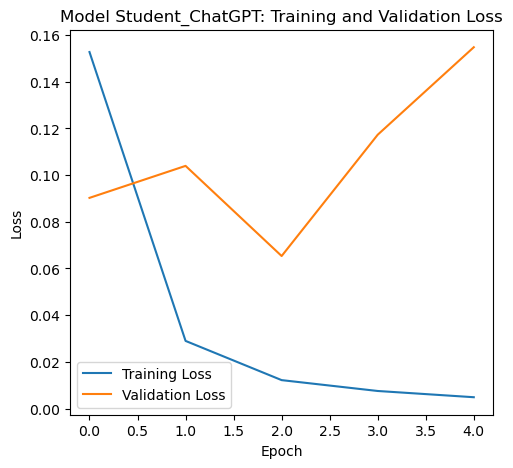

In [22]:
# Plot training history untuk model Student_ChatGPT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Student_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate Embeddings Function

In [23]:
def gen_emb(tokens, model, batch_size=32):
    """
    Generate embeddings using IndoBERT in batches.
    
    Args:
        tokens: Token from text.
        model: IndoBERT Semantic Similarity.
        batch_size: Number of samples per batch.
        
    Returns:
        np.ndarray: Embeddings.
    """
    embeddings = []
    
    num_batches = len(tokens['input_ids']) // batch_size + (len(tokens['input_ids']) % batch_size > 0)
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(tokens['input_ids']))

        batch_input_ids = tokens['input_ids'][start_idx:end_idx]
        batch_attention_mask = tokens['attention_mask'][start_idx:end_idx]
        
        batch_embeddings = model([batch_input_ids, batch_attention_mask])
        
        embeddings.append(batch_embeddings)
    
    return np.concatenate(embeddings, axis=0)

# Cosine Similarity Function

In [24]:
def cos_sim(embedding1, embedding2):
    """
    Calculate similarity score using standard cosine similarity.
    
    Args:
        embedding1: First embedding (input text)
        embedding2: Second embedding (reference)
        
    Returns:
        float: Average cosine similarity score
    """
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])

    avg_similarity = tf.reduce_mean(similarities).numpy()
    return avg_similarity


# Generate Embeddings (All Text)

In [25]:
# Generate embeddings for data test
print("Generating embeddings for Student (test set)...")
std_emb = gen_emb(std_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (test set)...")
gpt_emb = gen_emb(gpt_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (test set)...
Generating embeddings for ChatGPT (test set)...


# Measure Similarity Score (All Text)

In [26]:
std_std_sim_scores = []
std_gpt_sim_scores = []
for emb in std_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_sim_scores.append(avg_similarity)

gpt_std_sim_scores = []
gpt_gpt_sim_scores = []
for emb in gpt_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_sim_scores.append(avg_similarity)

std_sim_scores = np.array([
    std_std_sim_scores, 
    std_gpt_sim_scores
])

gpt_sim_scores = np.array([
    gpt_std_sim_scores, 
    gpt_gpt_sim_scores
])

# Visualization of Similarity Score (All Text)

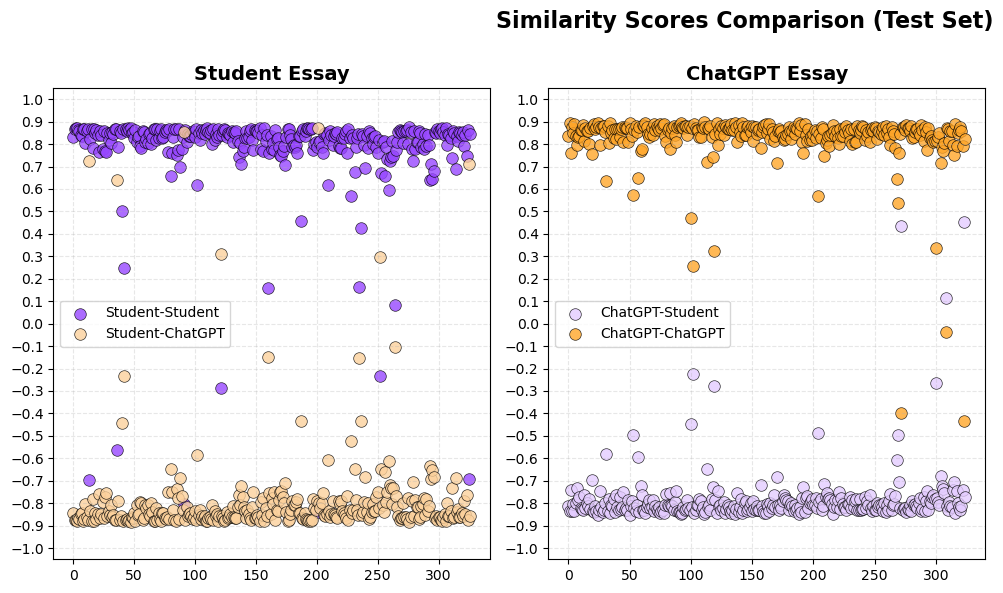

In [27]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(std_std_sim_scores)), std_std_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(std_gpt_sim_scores)), std_gpt_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt_std_sim_scores)), gpt_std_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt_gpt_sim_scores)), gpt_gpt_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Similarity Scores Comparison (Test Set)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  

os.makedirs('paper/images', exist_ok=True)
plt.savefig('paper/images/similarity_scores_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

# Generate Embeddings (Test Set)

In [28]:
# Generate embeddings for data test
print("Generating embeddings for Student (test set)...")
std_te_emb = gen_emb(std_te_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (test set)...")
gpt_te_emb = gen_emb(gpt_te_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (test set)...
Generating embeddings for ChatGPT (test set)...


# Measure Similarity Score (Test Set)

In [29]:
std_std_te_sim_scores = []
std_gpt_te_sim_scores = []
for emb in std_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_te_sim_scores.append(avg_similarity)

gpt_std_te_sim_scores = []
gpt_gpt_te_sim_scores = []
for emb in gpt_te_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_te_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_te_sim_scores.append(avg_similarity)

std_te_sim_scores = np.array([
    std_std_te_sim_scores, 
    std_gpt_te_sim_scores
])

gpt_te_sim_scores = np.array([
    gpt_std_te_sim_scores, 
    gpt_gpt_te_sim_scores
])

# Similarity Text Breakdown (Test Set)

In [30]:
test_pairs = []
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.width', 1000)        
pd.set_option('display.max_rows', None)      

for i, student_text in enumerate(std_txt):
    if i >= len(std_te_emb):
        continue
        
    student_embedding = tf.expand_dims(std_te_emb[i], 0)

    for j in range(len(gpt_txt)):
        if j >= len(gpt_te_emb):
            continue

        chatgpt_embedding = tf.expand_dims(gpt_te_emb[j], 0)
        similarity = cos_sim(student_embedding, chatgpt_embedding)
        
        test_pairs.append({
            'student_idx': i,
            'chatgpt_idx': j,
            'student_text': student_text,
            'chatgpt_text': gpt_txt[j],
            'similarity_score': similarity
        })

sorted_pairs = sorted(test_pairs, key=lambda x: x['similarity_score'], reverse=True)

result_v1 = sorted_pairs[:5]

df_v1 = pd.DataFrame(result_v1)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v1.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 1: Standard ===")
display(df_v1)

used_student_indices_v2 = set()
used_chatgpt_indices_v2 = set()
result_v2 = []

for pair in sorted_pairs:
    if (pair['student_idx'] in used_student_indices_v2 or 
        pair['chatgpt_idx'] in used_chatgpt_indices_v2):
        continue
    result_v2.append(pair)
    used_student_indices_v2.add(pair['student_idx'])
    used_chatgpt_indices_v2.add(pair['chatgpt_idx'])
    if len(result_v2) >= 5:
        break

df_v2 = pd.DataFrame(result_v2)[['student_text', 'chatgpt_text', 'similarity_score']]
df_v2.columns = ['Student Essay', 'ChatGPT Essay', 'Similarity Score']

print("=== 2: Unique ===")
display(df_v2)

=== 1: Standard ===


,Student Essay,ChatGPT Essay,Similarity Score
0,"banyak kesenian lain yang berpotensi memiliki nilai jual yang tinggi. bukan hanya kerajinan yang berbentuk fisik seperti batik. rupa-rupa tarian dan seni pertunjukkan dapat memiliki nilai ekonomi yang tinggi. tari kecak dari bali adalah salah satu contohnya turis domestik maupun mancanegara rela membayar untuk dapat menontonnya. pada akhirnya uang yang mereka keluarkan akan menjadi penyokong ekonomi indonesia. baik melalui devisa maupun keuntungan langsung yang mereka berikan kepada warga saat mereka membeli tiket, souvenir, kerajinan, dll..","kemajuan teknologi informasi juga bisa dimanfaatkan sebagai alat pemersatu. media sosial, misalnya, dapat menjadi jembatan untuk mengenalkan kultur dan kebiasaan lokal ke kancah global. platform digital mampu memperlihatkan sisi positif dari kebinekaan, sekaligus menjadi wadah untuk mengekspresikan kesepahaman.",0.949671
1,"ketujuh sumbangsih masyarakat, sumbangsih masyarakat juga merupakan nilai penting dalam membangun persatuan di lingkungan masyarakat multikultural. dalam masyarakat yang terdiri dari berbagai budaya, setiap budaya memiliki keunikan dan kekhasan yang dapat memberikan sumbangsih yang berbeda-beda. oleh karena itu, penting untuk mendorong partisipasi aktif masyarakat dalam memberikan sumbangsih yang positif bagi lingkungan sekitar. sumbangsih masyarakat dapat berupa berbagai bentuk, seperti partisipasi dalam kegiatan sosial atau kegiatan keagamaan, memberikan bantuan kepada sesama yang membutuhkan, atau bahkan hanya dengan memberikan dukungan moral kepada sesama. melalui upaya memperkuat nilai sumbangsih masyarakat, diharapkan masyarakat dapat merasakan manfaat dari keberagaman yang ada dan mampu membangun persatuan yang kuat di tengah-tengah masyarakat multikultural.",keberagaman: warna dalam kanvas kejayaan bangsa,0.946950
2,"ketujuh sumbangsih masyarakat, sumbangsih masyarakat juga merupakan nilai penting dalam membangun persatuan di lingkungan masyarakat multikultural. dalam masyarakat yang terdiri dari berbagai budaya, setiap budaya memiliki keunikan dan kekhasan yang dapat memberikan sumbangsih yang berbeda-beda. oleh karena itu, penting untuk mendorong partisipasi aktif masyarakat dalam memberikan sumbangsih yang positif bagi lingkungan sekitar. sumbangsih masyarakat dapat berupa berbagai bentuk, seperti partisipasi dalam kegiatan sosial atau kegiatan keagamaan, memberikan bantuan kepada sesama yang membutuhkan, atau bahkan hanya dengan memberikan dukungan moral kepada sesama. melalui upaya memperkuat nilai sumbangsih masyarakat, diharapkan masyarakat dapat merasakan manfaat dari keberagaman yang ada dan mampu membangun persatuan yang kuat di tengah-tengah masyarakat multikultural.","pendekatan kita terhadap keberagaman mempengaruhi bagaimana kita menyelesaikan permasalahan sosial, memajukan ekonomi, dan memperkuat persatuan. dalam konteks sosial, keberagaman mengajarkan kita untuk lebih toleran dan saling menghargai, mengakui perbedaan sebagai bagian dari kehidupan yang harmonis.",0.946875
3,"ketujuh sumbangsih masyarakat, sumbangsih masyarakat juga merupakan nilai penting dalam membangun persatuan di lingkungan masyarakat multikultural. dalam masyarakat yang terdiri dari berbagai budaya, setiap budaya memiliki keunikan dan kekhasan yang dapat memberikan sumbangsih yang berbeda-beda. oleh karena itu, penting untuk mendorong partisipasi aktif masyarakat dalam memberikan sumbangsih yang positif bagi lingkungan sekitar. sumbangsih masyarakat dapat berupa berbagai bentuk, seperti partisipasi dalam kegiatan sosial atau kegiatan keagamaan, memberikan bantuan kepada sesama yang membutuhkan, atau bahkan hanya dengan memberikan dukungan moral kepada sesama. melalui upaya memperkuat nilai sumbangsih masyarakat, diharapkan masyarakat dapat merasakan manfaat dari keberagaman yang ada dan mampu membangun persatuan yang kuat di tengah-tengah masyarakat multikultural.","namun, bukan berarti keberagaman tanpa tantangan. terkadang,

=== 2: Unique ===


,Student Essay,ChatGPT Essay,Similarity Score
0,"banyak kesenian lain yang berpotensi memiliki nilai jual yang tinggi. bukan hanya kerajinan yang berbentuk fisik seperti batik. rupa-rupa tarian dan seni pertunjukkan dapat memiliki nilai ekonomi yang tinggi. tari kecak dari bali adalah salah satu contohnya turis domestik maupun mancanegara rela membayar untuk dapat menontonnya. pada akhirnya uang yang mereka keluarkan akan menjadi penyokong ekonomi indonesia. baik melalui devisa maupun keuntungan langsung yang mereka berikan kepada warga saat mereka membeli tiket, souvenir, kerajinan, dll..","kemajuan teknologi informasi juga bisa dimanfaatkan sebagai alat pemersatu. media sosial, misalnya, dapat menjadi jembatan untuk mengenalkan kultur dan kebiasaan lokal ke kancah global. platform digital mampu memperlihatkan sisi positif dari kebinekaan, sekaligus menjadi wadah untuk mengekspresikan kesepahaman.",0.949671
1,"ketujuh sumbangsih masyarakat, sumbangsih masyarakat juga merupakan nilai penting dalam membangun persatuan di lingkungan masyarakat multikultural. dalam masyarakat yang terdiri dari berbagai budaya, setiap budaya memiliki keunikan dan kekhasan yang dapat memberikan sumbangsih yang berbeda-beda. oleh karena itu, penting untuk mendorong partisipasi aktif masyarakat dalam memberikan sumbangsih yang positif bagi lingkungan sekitar. sumbangsih masyarakat dapat berupa berbagai bentuk, seperti partisipasi dalam kegiatan sosial atau kegiatan keagamaan, memberikan bantuan kepada sesama yang membutuhkan, atau bahkan hanya dengan memberikan dukungan moral kepada sesama. melalui upaya memperkuat nilai sumbangsih masyarakat, diharapkan masyarakat dapat merasakan manfaat dari keberagaman yang ada dan mampu membangun persatuan yang kuat di tengah-tengah masyarakat multikultural.",keberagaman: warna dalam kanvas kejayaan bangsa,0.946950
2,"besarnya paparan teknologi pada gen z menjadikan mereka memiliki tingkat pemahaman dan penguasaan terhadap teknologi yang lebih tinggi dibandingkan berbagai generasi lainnya. utamanya, gen z menggunakan teknologi internet sebagai alat dalam berkomunikasi, belajar, dan berekspresi. dari ketiga hal tersebut, berekspresi menjadi tujuan utama bagi gen z dalam menggunakan teknologi internet. beragam platform media sosial seperti instagram, snapchat, tiktok, twitter, dan youtube menjadi sarana yang dimanfaatkan oleh gen z sebagai media mengekspresikan diri.","menyadari potensi besar keberagaman, tugas kita adalah memastikan bahwa setiap individu merasa dihargai tak peduli latar belakang mereka. dengan sikap saling menghargai, kita dapat memastikan bahwa keberagaman menjadi kekuatan, bukan halangan.",0.834206
3,"fenomena maraknya penyebaran berita bohong ‘hoax’ dan ujaran kebencian telah menjadi isu yang meresahkan. kemudahan dan kecepatan dalam mengakses berbagai platform media sosial meningkatkan kemungkinan informasi palsu tersebar di kalangan masyarakat. jenis pemberitaan yang ada juga beragam yakni mencakup isu-isu kesehatan, agama, budaya, politik, dan berbagai aspek kehidupan lainnya.","penting bagi kita untuk mengedepankan dialog antar budaya sebagai upaya pencegahan konflik. dialog terbuka dapat menjadi jembatan pemahaman dan mencegah salah tafsir yang sering kali menjadi pemicu perselisihan. edukasi tentang keberagaman harus dimulai sejak dini, agar generasi mendatang lebih siap menghadapi masyarakat yang multikultural.",0.788536
4,pesona world skin tone dari indonesia,"dalam dunia pendidikan, keberagaman kelas dapat memupuk toleransi generasi muda. pelajar yang hidup di lingkungan multikultural belajar mengenali dan menghargai perspektif berbeda sejak dini. hal ini menyiapkan mereka untuk menghadapi tantangan global di masa depan dengan lebih bijak dan terbuka.",0.625348


# Visualization of Similarity Score (Test Set)

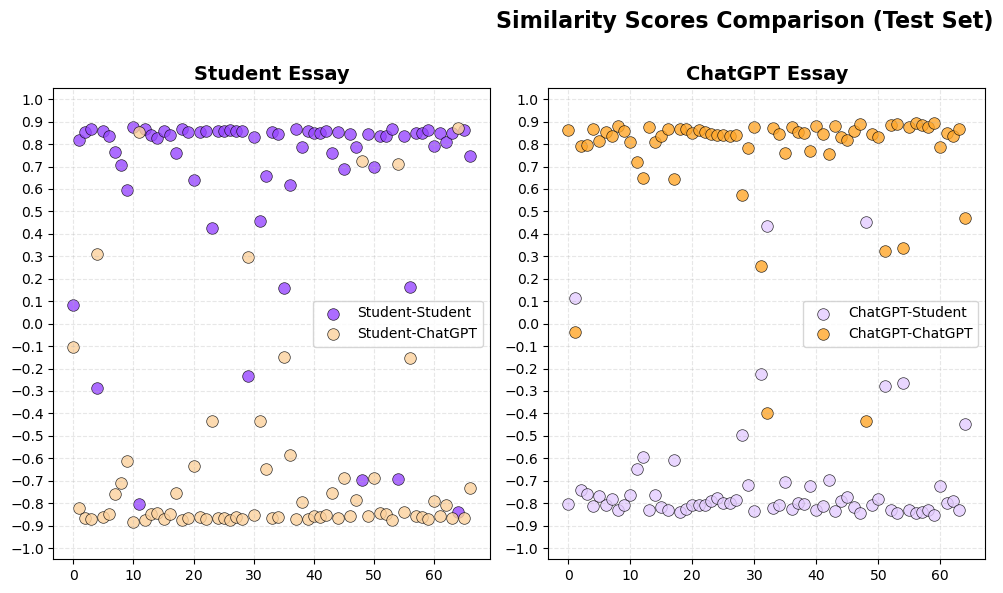

In [31]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(std_std_te_sim_scores)), std_std_te_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(std_gpt_te_sim_scores)), std_gpt_te_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt_std_te_sim_scores)), gpt_std_te_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt_gpt_te_sim_scores)), gpt_gpt_te_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('ChatGPT Essay', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Similarity Scores Comparison (Test Set)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  

os.makedirs('paper/images', exist_ok=True)
plt.savefig('paper/images/similarity_scores_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

# Generate Embeddings (Training & Validation Sets)

In [32]:
# Generate embeddings for training and validation sets
print("Generating embeddings for Student (training set)...")
std_tr_emb = gen_emb(std_tr_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (training set)...")
gpt_tr_emb = gen_emb(gpt_tr_tokens, semantic_model, batch_size=32)

print("Generating embeddings for Student (validation set)...")
std_va_emb = gen_emb(std_va_tokens, semantic_model, batch_size=32)
print("Generating embeddings for ChatGPT (validation set)...")
gpt_va_emb = gen_emb(gpt_va_tokens, semantic_model, batch_size=32)

Generating embeddings for Student (training set)...
Generating embeddings for ChatGPT (training set)...
Generating embeddings for Student (validation set)...
Generating embeddings for ChatGPT (validation set)...


# Measure Similarity Score (Training & Validation Sets)

In [33]:
# Training set
std_std_tr_sim_scores = []
std_gpt_tr_sim_scores = []
for emb in std_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_tr_sim_scores.append(avg_similarity)

gpt_std_tr_sim_scores = []
gpt_gpt_tr_sim_scores = []
for emb in gpt_tr_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_tr_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_tr_sim_scores.append(avg_similarity)

std_tr_sim_scores = np.array([
    std_std_tr_sim_scores, 
    std_gpt_tr_sim_scores
])

gpt_tr_sim_scores = np.array([
    gpt_std_tr_sim_scores, 
    gpt_gpt_tr_sim_scores
])

# Validation set
std_std_va_sim_scores = []
std_gpt_va_sim_scores = []
for emb in std_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    std_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    std_gpt_va_sim_scores.append(avg_similarity)

gpt_std_va_sim_scores = []
gpt_gpt_va_sim_scores = []
for emb in gpt_va_emb:
    avg_similarity = cos_sim(tf.expand_dims(emb, 0), std_emb)
    gpt_std_va_sim_scores.append(avg_similarity)

    avg_similarity = cos_sim(tf.expand_dims(emb, 0), gpt_emb)
    gpt_gpt_va_sim_scores.append(avg_similarity)

std_va_sim_scores = np.array([
    std_std_va_sim_scores, 
    std_gpt_va_sim_scores
])

gpt_va_sim_scores = np.array([
    gpt_std_va_sim_scores, 
    gpt_gpt_va_sim_scores
])

# Define Linguistic Features

In [34]:
def linguistic_features(text):
    """
    Features extraction from text:
    1.	Lexical Diversity
    2.	Total words in the essay
    3.	Total unique words*
    4.	Modals
    5.	Stopwords ratio*
    6.	Average sentence length*
    7.	Sentence length variation*
    8.	Punctuation Ratio*

    
    Args:
        text (str): Input text.
        
    Returns:
        dict: Linguistic features.
    """
    words = re.findall(r'\b\w+\b', text)
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    word_count = len(words)
    unique_count = len(set(words))
    
    ld = (unique_count / word_count * 100) if word_count > 0 else 0
    
    # Load modals from corpus file
    modals = set()
    if os.path.exists('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv'):
        with open('corpus/Indonesian_Manually_Tagged_Corpus_ID.tsv', 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    parts = line.strip().split('\t')
                    if len(parts) >= 2 and parts[1] == 'MD':
                        modals.add(parts[0].lower())
    
    # Count modals in text
    modal_count = sum(1 for word in words if word.lower() in modals)
    
    # Load stopwords from file
    stopwords = set()
    if os.path.exists('corpus/stopwords.txt'):
        with open('corpus/stopwords.txt', 'r', encoding='utf-8') as f:
            for line in f:
                stopwords.add(line.strip())
    
    # Calculate stopword ratio
    stopword_count = sum(1 for word in words if word.lower() in stopwords)
    stopword_ratio = (stopword_count / word_count * 100) if word_count > 0 else 0
    
    # Calculate sentence length statistics
    sentence_lengths = [len(re.findall(r'\b\w+\b', s)) for s in sentences]
    avg_sent_len = np.mean(sentence_lengths) if sentence_lengths else 0
    sent_len_var = np.std(sentence_lengths) if len(sentence_lengths) > 1 else 0
    
    # Calculate punctuation ratio
    punct_count = len(re.findall(r'[.!?]', text))
    punct_ratio = (punct_count / word_count) * 100 if word_count > 0 else 0

    return {
        'lexical_diversity': ld,
        'total_words': word_count,
        'total_unique_words': unique_count,
        'modals': modal_count,
        'stopwords_ratio': stopword_ratio,
        'avg_sentence_length': avg_sent_len,
        'sentence_length_variation': sent_len_var,
        'punctuation_ratio': punct_ratio
    }

# Features Extraction (All Text)

In [35]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student...")
std_features = [linguistic_features(text) for text in std_txt]

print("Features extraction for ChatGPT...")
gpt_features = [linguistic_features(text) for text in gpt_txt]


# convert
std_features_df = pd.DataFrame(std_features)
gpt_features_df = pd.DataFrame(gpt_features)


# Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features:")
display(std_features_df.head())

print("\nChatGPT Linguistic Features:")
display(gpt_features_df.head())

Features extraction for Student...
Features extraction for ChatGPT...

Student Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,100.000000,8,8,0,25.000000,8.000000,0.000000,0.000000
1,61.111111,108,66,1,45.370370,12.000000,6.582806,9.259259
2,72.881356,118,86,2,37.288136,8.428571,6.935563,11.864407
3,82.653061,98,81,0,36.734694,10.888889,7.030796,9.183673
4,71.929825,57,41,0,36.842105,19.000000,9.933110,5.263158



ChatGPT Linguistic Features:


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,100.000000,10,10,1,20.000000,10.00,0.000000,0.000000
1,85.483871,62,53,2,46.774194,15.50,3.640055,6.451613
2,84.507042,71,60,2,40.845070,14.20,3.919184,7.042254
3,86.792453,53,46,3,49.056604,13.25,2.861381,7.547170
4,81.355932,59,48,3,42.372881,14.75,2.165064,6.779661


# Normalize Linguistic Features (All Text)

In [36]:
# Combine features into a single DataFrame
all_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

# Separate normalized features back into student and ChatGPT
n_student = len(std_features_df)
n_chatgpt = len(gpt_features_df)

std_features_norm = normalized_features[:n_student]
gpt_features_norm = normalized_features[n_student:n_student + n_chatgpt]

print("Student features after normalization:")
print(std_features_norm[:5])

print("ChatGPT features after normalization:")
print(gpt_features_norm[:5])

# Save scaler for later inference
try:
    with open('paper/scaler_stylometric.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("Scaler saved successfully.")
except Exception as e:
    print(f"Error saving scaler: {e}")

Student features after normalization:
[[ 2.06778297 -1.88249995 -2.10542354 -1.14126644 -1.90442672 -1.56097164
  -1.52943068 -1.66006487]
 [-2.19968199  1.52256571  0.84823044 -0.58178845 -0.13757576 -0.77166664
   0.86605439  0.85939268]
 [-0.90807637  1.86307228  1.86673181 -0.02231047 -0.83859906 -1.47640325
   0.99442299  1.56825701]
 [ 0.16421988  1.18205915  1.61210647 -1.14126644 -0.88660256 -0.99091803
   1.0290783   0.83882568]
 [-1.01249249 -0.21401778 -0.42489628 -1.14126644 -0.87728609  0.6096171
   2.08523095 -0.22795216]]
ChatGPT features after normalization:
[[ 2.06778297 -1.81439864 -2.00357341 -0.58178845 -2.33810832 -1.16631914
  -1.52943068 -1.66006487]
 [ 0.47485826 -0.04376449  0.18620455 -0.02231047 -0.01581331 -0.08102477
  -0.20481357  0.09542813]
 [ 0.36766615  0.26269142  0.54268003 -0.02231047 -0.53008363 -0.3375489
  -0.10323858  0.25614228]
 [ 0.61845525 -0.3502204  -0.17027094  0.53716751  0.18215456 -0.52500883
  -0.48817334  0.39353072]
 [ 0.02187967 -0

In [37]:
# Add labels to features
std_features_df['label'] = 'Student Essay'
gpt_features_df['label'] = 'ChatGPT Essay'

# Combine datasets
combined_features = pd.concat([std_features_df, gpt_features_df], axis=0)

# Visualize Linguistic Features (All Texts)

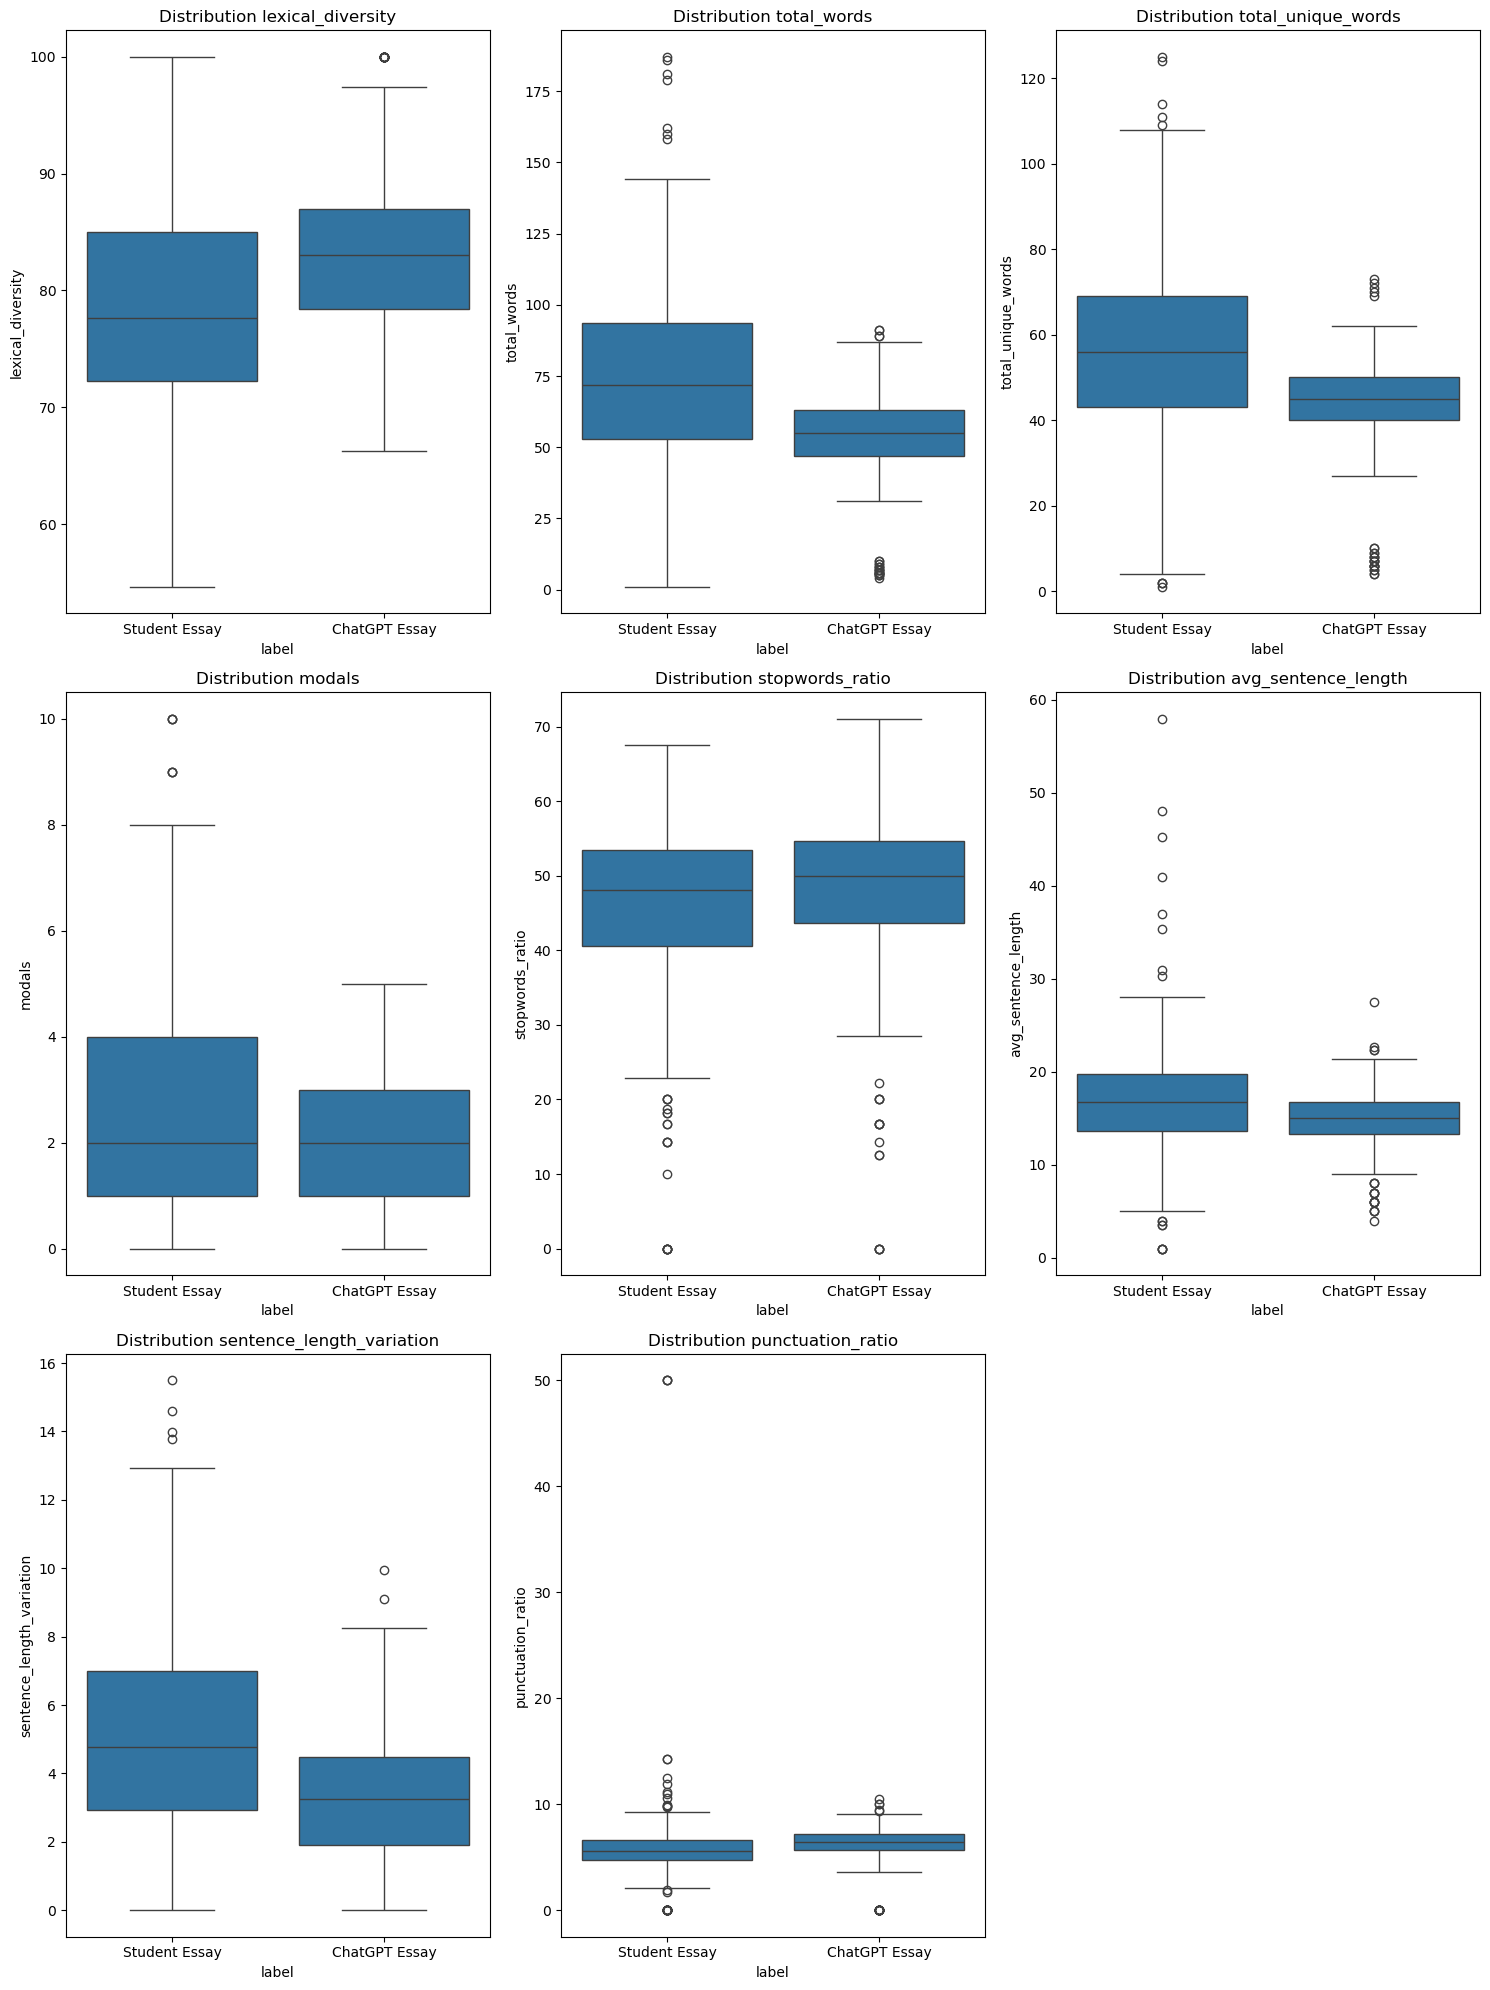

In [38]:
plt.figure(figsize=(15, 20))
for i, feature in enumerate([
    'lexical_diversity',
    'total_words',
    'total_unique_words',
    'modals',
    'stopwords_ratio',
    'avg_sentence_length',
    'sentence_length_variation',
    'punctuation_ratio'
]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='label', y=feature, data=combined_features)
    plt.title(f'Distribution {feature}')
plt.tight_layout()
plt.show()

# Feature Extraction (Training, Validation, & Test Sets)

In [39]:
# Feature extraction for Student and ChatGPT essays
print("Features extraction for Student (training set)...")
std_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (training set)...")
gpt_tr_features = [linguistic_features(text) for text in train_set[train_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (validation set)...")
std_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (validation set)...")
gpt_va_features = [linguistic_features(text) for text in val_set[val_set['label'] == 1]['text'].tolist()]

print("Features extraction for Student (test set)...")
std_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 0]['text'].tolist()]
print("Features extraction for ChatGPT (test set)...")
gpt_te_features = [linguistic_features(text) for text in test_set[test_set['label'] == 1]['text'].tolist()]

# convert
std_tr_features_df = pd.DataFrame(std_tr_features)
gpt_tr_features_df = pd.DataFrame(gpt_tr_features)

std_va_features_df = pd.DataFrame(std_va_features)
gpt_va_features_df = pd.DataFrame(gpt_va_features)

std_te_features_df = pd.DataFrame(std_te_features)
gpt_te_features_df = pd.DataFrame(gpt_te_features)

#Show the first few rows of the features DataFrames
print("\nStudent Linguistic Features (Test Set):")
display(std_te_features_df.head())

print("\nChatGPT Linguistic Features (Test Set):")
display(gpt_te_features_df.head())

Features extraction for Student (training set)...
Features extraction for ChatGPT (training set)...
Features extraction for Student (validation set)...
Features extraction for ChatGPT (validation set)...
Features extraction for Student (test set)...
Features extraction for ChatGPT (test set)...

Student Linguistic Features (Test Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,84.210526,57,48,1,50.877193,19.000000,7.788881,5.263158
1,76.136364,88,67,3,46.590909,17.600000,4.498889,5.681818
2,86.075949,79,68,3,46.835443,11.285714,5.283783,8.860759
3,58.288770,187,109,7,55.080214,18.700000,6.870953,5.347594
4,100.000000,6,6,0,0.000000,6.000000,0.000000,0.000000



ChatGPT Linguistic Features (Test Set):


,lexical_diversity,total_words,total_unique_words,modals,stopwords_ratio,avg_sentence_length,sentence_length_variation,punctuation_ratio
0,82.456140,57,47,2,54.385965,19.00,2.828427,5.263158
1,85.074627,67,57,2,53.731343,16.75,3.960745,5.970149
2,83.333333,48,40,4,54.166667,16.00,6.683313,6.250000
3,81.481481,54,44,2,66.666667,13.50,5.678908,7.407407
4,80.327869,61,49,3,42.622951,15.25,6.179604,6.557377


In [40]:
std_tr_features_df.shape, gpt_tr_features_df.shape, std_va_features_df.shape, gpt_va_features_df.shape, std_te_features_df.shape, gpt_te_features_df.shape

((243, 8), (244, 8), (17, 8), (16, 8), (67, 8), (65, 8))

# Normalize Linguistic Features (Training, Validation, & Test Sets)

In [41]:
# Combine features into a single DataFrame
all_tr_features = pd.concat([std_tr_features_df, gpt_tr_features_df], axis=0)
all_va_features = pd.concat([std_va_features_df, gpt_va_features_df], axis=0)
all_te_features = pd.concat([std_te_features_df, gpt_te_features_df], axis=0)

# Normalize features
scaler = StandardScaler()
normalized_tr_features = scaler.fit_transform(all_tr_features)
normalized_va_features = scaler.fit_transform(all_va_features)
normalized_te_features = scaler.fit_transform(all_te_features)

# Separate normalized features back into student and ChatGPT
n_student_tr = len(std_tr_features_df)
n_chatgpt_tr = len(gpt_tr_features_df)

n_student_va = len(std_va_features_df)
n_chatgpt_va = len(gpt_va_features_df)

n_student_te = len(std_te_features_df)
n_chatgpt_te = len(gpt_te_features_df)

std_tr_features_norm = normalized_tr_features[:n_student_tr]
gpt_tr_features_norm = normalized_tr_features[n_student_tr:n_student_tr + n_chatgpt_tr]

std_va_features_norm = normalized_va_features[:n_student_va]
gpt_va_features_norm = normalized_va_features[n_student_va:n_student_va + n_chatgpt_va]

std_te_features_norm = normalized_te_features[:n_student_te]
gpt_te_features_norm = normalized_te_features[n_student_te:n_student_te + n_chatgpt_te]

print("Student features after normalization (training):")
print(std_tr_features_norm[:5])

print("ChatGPT features after normalization (training):")
print(gpt_tr_features_norm[:5])

Student features after normalization (training):
[[-0.13369815  1.17578486  1.42854927  0.01853892 -0.55320354  0.00529102
   0.07468522  0.04703817]
 [ 0.71136204 -0.74829856 -0.65393911  0.01853892 -0.26959199 -0.45902686
  -0.56515104  0.30859383]
 [-1.04370368  2.82000161  2.74915166 -0.54573943 -0.37733578  1.56407248
   2.27809452 -0.45647608]
 [-2.59703631  1.07083486  0.26032408  1.14709561 -0.16065792  0.5226738
  -0.36177599 -0.16710802]
 [-2.06670425  1.77050156  1.12379488 -1.11001777 -0.46944504  0.56910559
   0.06691636 -0.18343503]]
ChatGPT features after normalization (training):
[[ 0.27374321 -0.01364853  0.15873929 -0.54573943 -0.43980147 -0.09420567
  -0.47762206  0.09645652]
 [-1.23923518  0.40615149  0.15873929  0.01853892  1.07662704  0.50277447
  -0.36122379 -0.15998465]
 [ 2.06798041 -1.83278195 -1.97454149 -0.54573943 -2.33797767 -1.18866924
  -1.49295181 -1.4849307 ]
 [ 1.01852092 -0.32849854 -0.04443031  0.01853892 -0.63994214  0.33694665
   0.27057835 -0.097

In [42]:
# Check dimensions of your embedding arrays
print("std_te_emb shape:", std_te_emb.shape)
print("gpt_te_emb shape:", gpt_te_emb.shape)


# Print shapes of the resulting similarity scores
print("std_std_te_sim_scores shape:", np.array(std_std_te_sim_scores).shape)
print("std_gpt_te_sim_scores shape:", np.array(std_gpt_te_sim_scores).shape)
print("gpt_std_te_sim_scores shape:", np.array(gpt_std_te_sim_scores).shape)
print("gpt_gpt_te_sim_scores shape:", np.array(gpt_gpt_te_sim_scores).shape)

# Check shapes of the combined arrays
print("std_te_sim_scores shape:", std_te_sim_scores.shape)
print("gpt_te_sim_scores shape:", gpt_te_sim_scores.shape)

print("std_te_features_norm shape:", std_te_features_norm.shape)
print("gpt_te_features_norm shape:", gpt_te_features_norm.shape)

std_te_emb shape: (67, 256)
gpt_te_emb shape: (65, 256)
std_std_te_sim_scores shape: (67,)
std_gpt_te_sim_scores shape: (67,)
gpt_std_te_sim_scores shape: (65,)
gpt_gpt_te_sim_scores shape: (65,)
std_te_sim_scores shape: (2, 67)
gpt_te_sim_scores shape: (2, 65)
std_te_features_norm shape: (67, 8)
gpt_te_features_norm shape: (65, 8)


# Data Preparation for Classification

In [43]:
# Combine embeddings for model 1 (already correct)
emb_tr_features = np.vstack([std_tr_emb, gpt_tr_emb])
emb_va_features = np.vstack([std_va_emb, gpt_va_emb])
emb_te_features = np.vstack([std_te_emb, gpt_te_emb])

std_tr_features_selected = std_tr_features_norm
gpt_tr_features_selected = gpt_tr_features_norm

std_va_features_selected = std_va_features_norm
gpt_va_features_selected = gpt_va_features_norm

std_te_features_selected = std_te_features_norm
gpt_te_features_selected = gpt_te_features_norm

linguistic_tr_features = np.vstack([
    std_tr_features_selected,
    gpt_tr_features_selected
])
linguistic_va_features = np.vstack([
    std_va_features_selected,
    gpt_va_features_selected
])
linguistic_te_features = np.vstack([
    std_te_features_selected,
    gpt_te_features_selected
])

std_tr_sim_scores_transposed = std_tr_sim_scores.T 
gpt_tr_sim_scores_transposed = gpt_tr_sim_scores.T
similarity_tr_scores = np.vstack([
    std_tr_sim_scores_transposed,
    gpt_tr_sim_scores_transposed,
])

std_va_sim_scores_transposed = std_va_sim_scores.T 
gpt_va_sim_scores_transposed = gpt_va_sim_scores.T
similarity_va_scores = np.vstack([
    std_va_sim_scores_transposed,
    gpt_va_sim_scores_transposed,
])
std_te_sim_scores_transposed = std_te_sim_scores.T 
gpt_te_sim_scores_transposed = gpt_te_sim_scores.T
similarity_te_scores = np.vstack([
    std_te_sim_scores_transposed,
    gpt_te_sim_scores_transposed,
])

# Create labels
std_tr_labels = np.zeros(len(train_set[train_set['label'] == 0]))
gpt_tr_labels = np.ones(len(train_set[train_set['label'] == 1]))
tr_labels = np.hstack([std_tr_labels, gpt_tr_labels])

# Validation set labels
std_va_labels = np.zeros(len(val_set[val_set['label'] == 0]))
gpt_va_labels = np.ones(len(val_set[val_set['label'] == 1]))
va_labels = np.hstack([std_va_labels, gpt_va_labels])

# Test set labels
std_te_labels = np.zeros(len(test_set[test_set['label'] == 0]))
gpt_te_labels = np.ones(len(test_set[test_set['label'] == 1]))
te_labels = np.hstack([std_te_labels, gpt_te_labels])

tr_labels = tr_labels.astype(int)
va_labels = va_labels.astype(int)
te_labels = te_labels.astype(int)

# Verify shapes
print(f"emb_te_features shape: {emb_te_features.shape}")
print(f"linguistic_te_features shape: {linguistic_te_features.shape}")
print(f"similarity_te_scores shape: {similarity_te_scores.shape}")
print(f"te_labels shape: {te_labels.shape}")

print(f"emb_te_features value: {emb_te_features[:5]}")
print(f"linguistic_te_features value: {linguistic_te_features[:5]}")
print(f"similarity_te_scores value: {similarity_te_scores[:5]}")
print(f"te_labels value: {te_labels[:5]}")


emb_te_features shape: (132, 256)
linguistic_te_features shape: (132, 8)
similarity_te_scores shape: (132, 2)
te_labels shape: (132,)
emb_te_features value: [[ 0.04894689  0.02746127  0.0031697  ...  0.08083263  0.08754145
  -0.07154976]
 [-0.09094667  0.09710659  0.02305195 ...  0.06548229  0.06853942
  -0.05383592]
 [-0.11623704  0.13152012  0.0352407  ...  0.06912425  0.08733039
  -0.06655677]
 [-0.10313194  0.11435745  0.02510597 ...  0.05451348  0.06883881
  -0.05511462]
 [ 0.07776798 -0.00650816 -0.09798175 ... -0.00498418 -0.03213613
  -0.00967934]]
linguistic_te_features value: [[ 0.37223373 -0.24805045 -0.10378759 -0.6537575   0.39651982  0.60778103
   1.44112704 -0.44879592]
 [-0.4910071   0.75394605  0.87111605  0.41162509  0.0286355   0.35340954
   0.14292147 -0.25444574]
 [ 0.57167352  0.46304384  0.92242677  0.41162509  0.04962342 -0.79385781
   0.45263486  1.22128015]
 [-2.39916426  3.95387036  3.02616619  2.54239027  0.75725783  0.55327286
   1.07891988 -0.40959924]
 [ 

# Build Classification Model

In [44]:
emb_input = tf.keras.layers.Input(
    shape=(256,),
    dtype=tf.float32, 
    name="embeddings"
)

sim_score_input = tf.keras.layers.Input(
    shape=(2,), 
    dtype=tf.float32, 
    name="similarity_score"
)

linguistic_input = tf.keras.layers.Input(
    shape=(8,),
    dtype=tf.float32, 
    name="linguistic_features"
)

emb_dense = tf.keras.layers.Dense(128, activation="relu")(emb_input)
sim_dense = tf.keras.layers.Dense(16, activation="relu")(sim_score_input)
lin_dense = tf.keras.layers.Dense(64, activation="relu")(linguistic_input)

combined = tf.keras.layers.Concatenate()([emb_dense, sim_dense, lin_dense])

x = tf.keras.layers.Dense(128, activation="relu")(combined)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

classifier = tf.keras.Model(
    inputs=[emb_input, sim_score_input, linguistic_input],
    outputs=output,
    name="text_classifier"
)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

classifier.summary()

Model: "text_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embeddings (InputLayer)     [(None, 256)]                0         []                            
                                                                                                  
 similarity_score (InputLay  [(None, 2)]                  0         []                            
 er)                                                                                              
                                                                                                  
 linguistic_features (Input  [(None, 8)]                  0         []                            
 Layer)                                                                                           
                                                                                    

# Create Data Input for Classification

In [45]:
train_inputs = {
    "embeddings": emb_tr_features,
    "similarity_score": similarity_tr_scores,
    "linguistic_features": linguistic_tr_features
}

val_inputs = {
    "embeddings": emb_va_features,
    "similarity_score": similarity_va_scores,
    "linguistic_features": linguistic_va_features
}


test_inputs = {
    "embeddings": emb_te_features,
    "similarity_score": similarity_te_scores,
    "linguistic_features": linguistic_te_features
}

train_labels = tr_labels
val_labels = va_labels
test_labels = te_labels

# Train Classification Model

Training Classification Model...
Epoch 1/10
31/31 [==============================] - 2s 12ms/step - loss: 0.6515 - accuracy: 0.7639 - precision: 0.7115 - recall: 0.8893 - auc: 0.8335 - val_loss: 0.6091 - val_accuracy: 0.8788 - val_precision: 0.8333 - val_recall: 0.9375 - val_auc: 0.9228
Epoch 2/10
31/31 [==============================] - 0s 7ms/step - loss: 0.5492 - accuracy: 0.9795 - precision: 0.9718 - recall: 0.9877 - auc: 0.9957 - val_loss: 0.4993 - val_accuracy: 0.9697 - val_precision: 0.9412 - val_recall: 1.0000 - val_auc: 0.9779
Epoch 3/10
31/31 [==============================] - 0s 7ms/step - loss: 0.4093 - accuracy: 0.9979 - precision: 0.9959 - recall: 1.0000 - auc: 0.9997 - val_loss: 0.3639 - val_accuracy: 0.9697 - val_precision: 0.9412 - val_recall: 1.0000 - val_auc: 0.9945
Epoch 4/10
31/31 [==============================] - 0s 7ms/step - loss: 0.2586 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.2350 - val_accuracy: 0.9697 - val_precisi

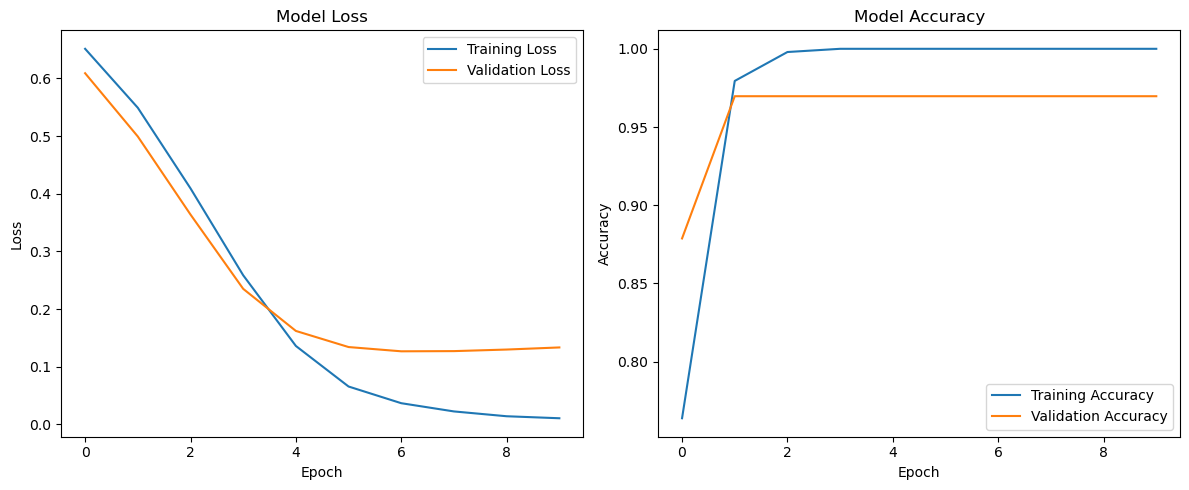

In [46]:
# Training classifier
print("Training Classification Model...")
history_classifier = classifier.fit(
    train_inputs,
    train_labels,
    validation_data=(val_inputs, val_labels),
    epochs=10,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluation Model

Making predictions on all data (train + validation + test)...
21/21 [==============================] - 0s 1ms/step
Evaluating model on all data...
Combined Loss: 0.0670
Combined Accuracy: 0.9862
Combined Precision: 0.9788
Combined Recall: 0.9938
Combined AUC: 0.9929


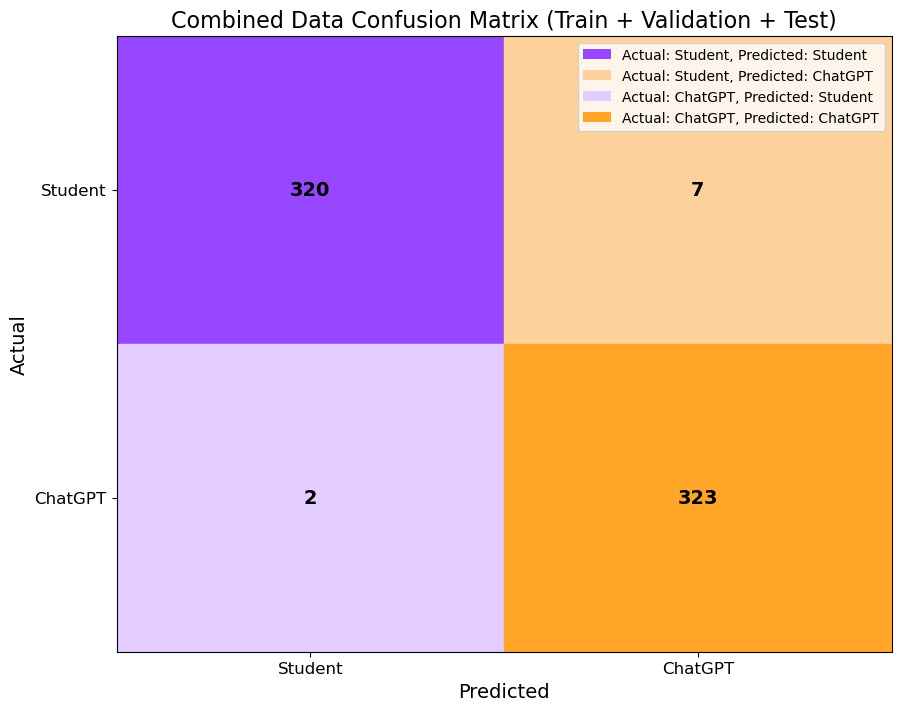


Combined Data Classification Report (Train + Validation + Test):
              precision    recall  f1-score   support

     Student       0.99      0.98      0.99       327
     ChatGPT       0.98      0.99      0.99       325

    accuracy                           0.99       652
   macro avg       0.99      0.99      0.99       652
weighted avg       0.99      0.99      0.99       652



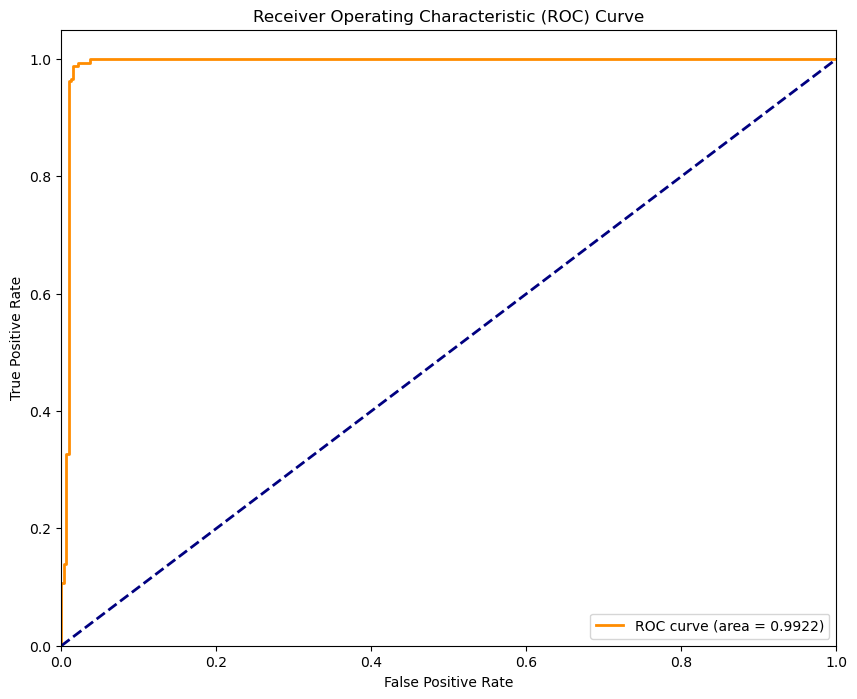

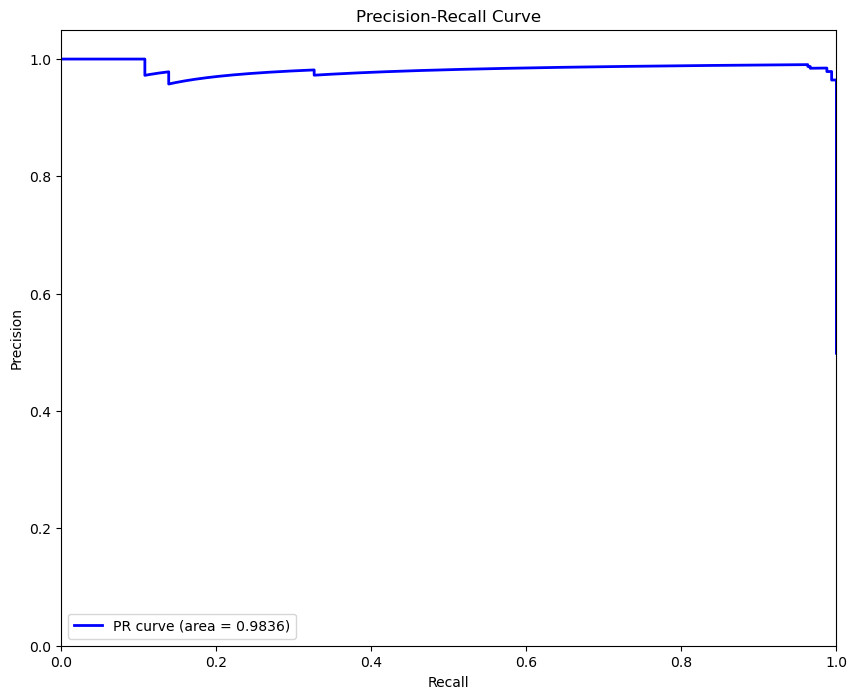


Metrics by dataset split:
--------------------------------------------------
16/16 [==============================] - 0s 2ms/step
Training set:   Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
2/2 [==============================] - 0s 2ms/step
Validation set: Acc: 0.9697, Prec: 0.9412, Rec: 1.0000, F1: 0.9697
5/5 [==============================] - 0s 2ms/step
Test set:      Acc: 0.9394, Prec: 0.9130, Rec: 0.9692, F1: 0.9403
Combined:      Acc: 0.9862, Prec: 0.9788, Rec: 0.9938, F1: 0.9863


In [47]:
# Combine all inputs and labels
combined_inputs = {
    "embeddings": np.concatenate([train_inputs["embeddings"], val_inputs["embeddings"], test_inputs["embeddings"]]),
    "similarity_score": np.concatenate([train_inputs["similarity_score"], val_inputs["similarity_score"], test_inputs["similarity_score"]]),
    "linguistic_features": np.concatenate([train_inputs["linguistic_features"], val_inputs["linguistic_features"], test_inputs["linguistic_features"]])
}

combined_labels = np.concatenate([train_labels, val_labels, test_labels])

# Make predictions on combined data
print("Making predictions on all data (train + validation + test)...")
combined_predictions = classifier.predict(combined_inputs)
combined_predictions_binary = (combined_predictions > 0.5).astype(int)

# Evaluate on combined data
print("Evaluating model on all data...")
combined_loss, combined_acc, combined_precision, combined_recall, combined_auc = classifier.evaluate(
    combined_inputs, combined_labels, verbose=0
)
print(f"Combined Loss: {combined_loss:.4f}")
print(f"Combined Accuracy: {combined_acc:.4f}")
print(f"Combined Precision: {combined_precision:.4f}")
print(f"Combined Recall: {combined_recall:.4f}")
print(f"Combined AUC: {combined_auc:.4f}")

# Confusion matrix for combined data
cm_combined = confusion_matrix(combined_labels, combined_predictions_binary)

# Define the custom colors for the confusion matrix
student_student_color = "#9747FF"  # Actual student, predicted student
student_chatgpt_color = "#FCD19C"  # Actual student, predicted ChatGPT
chatgpt_chatgpt_color = "#FFA629"  # Actual ChatGPT, predicted ChatGPT
chatgpt_student_color = "#E4CCFF"  # Actual ChatGPT, predicted student

# Create a custom colormap for the confusion matrix
colors = np.array([[student_student_color, student_chatgpt_color], 
                   [chatgpt_student_color, chatgpt_chatgpt_color]])

# Visualizing confusion matrix for combined data with custom colors
plt.figure(figsize=(10, 8))

# Create a meshgrid for the custom colormap
rows, cols = cm_combined.shape
row_ind, col_ind = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

# Plot the confusion matrix with custom colors
for i in range(rows):
    for j in range(cols):
        plt.fill_between([j, j+1], [rows-i-1, rows-i-1], [rows-i, rows-i], color=colors[i, j])
        plt.text(j+0.5, rows-i-0.5, str(cm_combined[i, j]), ha='center', va='center', 
                 color='black' if i == 0 and j == 0 else 'black', fontsize=14, fontweight='bold')

plt.title('Combined Data Confusion Matrix (Train + Validation + Test)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks([0.5, 1.5], ['Student', 'ChatGPT'], fontsize=12)
plt.yticks([0.5, 1.5], ['ChatGPT', 'Student'], fontsize=12)
plt.xlim(0, 2)
plt.ylim(0, 2)

# Create a legend for the custom colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=student_student_color, label='Actual: Student, Predicted: Student'),
    Patch(facecolor=student_chatgpt_color, label='Actual: Student, Predicted: ChatGPT'),
    Patch(facecolor=chatgpt_student_color, label='Actual: ChatGPT, Predicted: Student'),
    Patch(facecolor=chatgpt_chatgpt_color, label='Actual: ChatGPT, Predicted: ChatGPT')
]
plt.legend(handles=legend_elements, loc='best', fontsize=10)

plt.show()

# Classification report for combined data
print("\nCombined Data Classification Report (Train + Validation + Test):")
print(classification_report(combined_labels, combined_predictions_binary, target_names=['Student', 'ChatGPT']))

# ROC curve
fpr, tpr, thresholds = roc_curve(combined_labels, combined_predictions)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(combined_labels, combined_predictions)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Optional: Calculate and display metrics by dataset split
print("\nMetrics by dataset split:")
print("-" * 50)

# Train set metrics
train_predictions = classifier.predict(train_inputs)
train_predictions_binary = (train_predictions > 0.5).astype(int)
train_acc = accuracy_score(train_labels, train_predictions_binary)
train_prec = precision_score(train_labels, train_predictions_binary)
train_rec = recall_score(train_labels, train_predictions_binary)
train_f1 = f1_score(train_labels, train_predictions_binary)

print(f"Training set:   Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")

# Validation set metrics
val_predictions = classifier.predict(val_inputs)
val_predictions_binary = (val_predictions > 0.5).astype(int)
val_acc = accuracy_score(val_labels, val_predictions_binary)
val_prec = precision_score(val_labels, val_predictions_binary)
val_rec = recall_score(val_labels, val_predictions_binary)
val_f1 = f1_score(val_labels, val_predictions_binary)

print(f"Validation set: Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")

# Test set metrics
test_predictions = classifier.predict(test_inputs)
test_predictions_binary = (test_predictions > 0.5).astype(int)
test_acc = accuracy_score(test_labels, test_predictions_binary)
test_prec = precision_score(test_labels, test_predictions_binary)
test_rec = recall_score(test_labels, test_predictions_binary)
test_f1 = f1_score(test_labels, test_predictions_binary)

print(f"Test set:      Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}")
print(f"Combined:      Acc: {combined_acc:.4f}, Prec: {combined_precision:.4f}, Rec: {combined_recall:.4f}, F1: {2*combined_precision*combined_recall/(combined_precision+combined_recall):.4f}")

Evaluating model on test set...
Test Loss: 0.2130
Test Accuracy: 0.9394
Test Precision: 0.9130
Test Recall: 0.9692
Test AUC: 0.9582
Making predictions on test set...
5/5 [==============================] - 0s 2ms/step


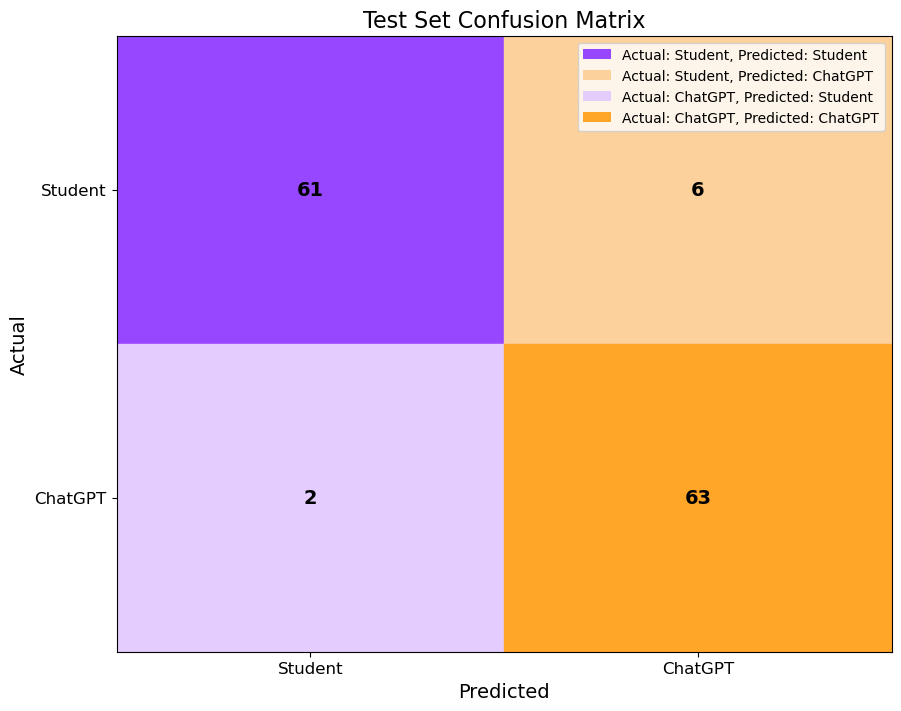


Test Set Classification Report:
              precision    recall  f1-score   support

     Student       0.97      0.91      0.94        67
     ChatGPT       0.91      0.97      0.94        65

    accuracy                           0.94       132
   macro avg       0.94      0.94      0.94       132
weighted avg       0.94      0.94      0.94       132



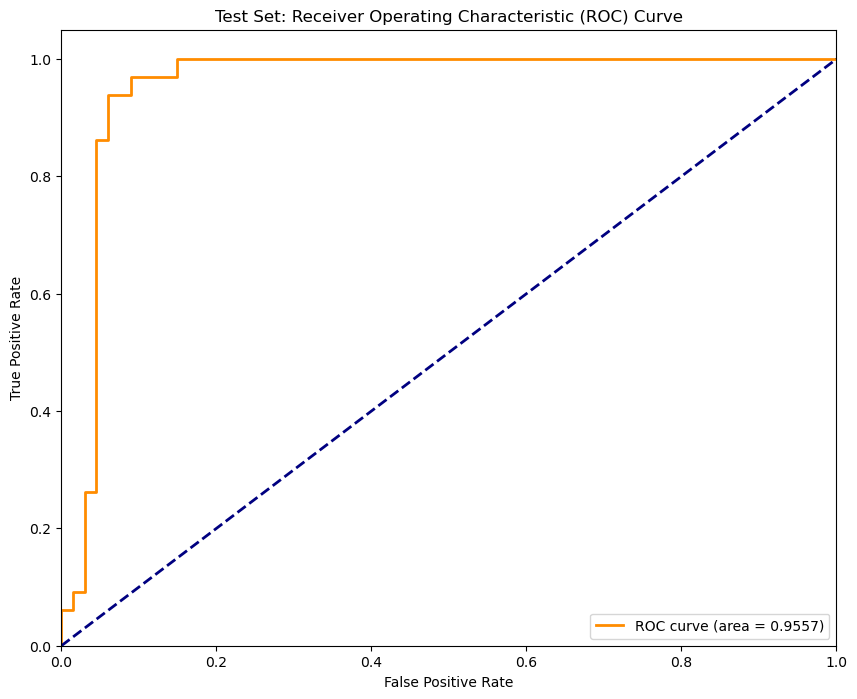

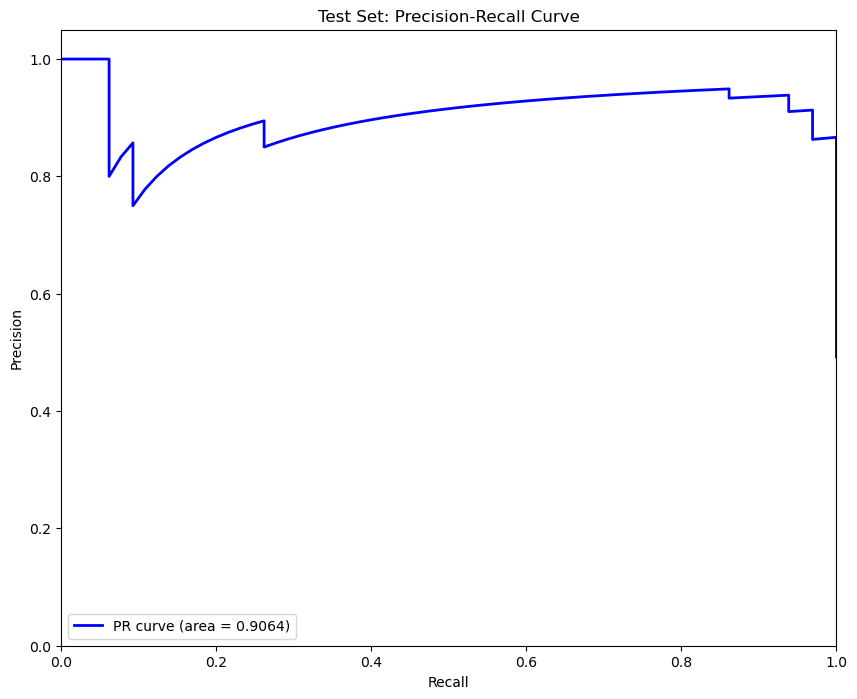

In [48]:
# Model evaluation on test set
print("Evaluating model on test set...")
test_loss, test_acc, test_precision, test_recall, test_auc = classifier.evaluate(
    test_inputs, test_labels, verbose=0
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Make predictions on test set
print("Making predictions on test set...")
test_predictions = classifier.predict(test_inputs)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Confusion matrix for test set
cm_test = confusion_matrix(test_labels, test_predictions_binary)

# Custom color mapping for confusion matrix
import matplotlib.colors as mcolors
import numpy as np

# Define the custom colors for the confusion matrix
student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Create a custom colormap for the confusion matrix
colors = np.array([[student_student_color, student_chatgpt_color], 
                   [chatgpt_student_color, chatgpt_chatgpt_color]])

# Visualizing confusion matrix for test set with custom colors
plt.figure(figsize=(10, 8))

# Create a meshgrid for the custom colormap
rows, cols = cm_test.shape
row_ind, col_ind = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

# Plot the confusion matrix with custom colors
for i in range(rows):
    for j in range(cols):
        plt.fill_between([j, j+1], [rows-i-1, rows-i-1], [rows-i, rows-i], color=colors[i, j])
        plt.text(j+0.5, rows-i-0.5, str(cm_test[i, j]), ha='center', va='center', 
                 color='black' if i == 0 and j == 0 else 'black', fontsize=14, fontweight='bold')

plt.title('Test Set Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks([0.5, 1.5], ['Student', 'ChatGPT'], fontsize=12)
plt.yticks([0.5, 1.5], ['ChatGPT', 'Student'], fontsize=12)
plt.xlim(0, 2)
plt.ylim(0, 2)

# Create a legend for the custom colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=student_student_color, label='Actual: Student, Predicted: Student'),
    Patch(facecolor=student_chatgpt_color, label='Actual: Student, Predicted: ChatGPT'),
    Patch(facecolor=chatgpt_student_color, label='Actual: ChatGPT, Predicted: Student'),
    Patch(facecolor=chatgpt_chatgpt_color, label='Actual: ChatGPT, Predicted: ChatGPT')
]
plt.legend(handles=legend_elements, loc='best', fontsize=10)

plt.show()

# Classification report for test set
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_predictions_binary, target_names=['Student', 'ChatGPT']))

# ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(test_labels, test_predictions)
roc_auc_test = auc(fpr_test, tpr_test)

# Precision-Recall curve for test set
precision_test, recall_test, _ = precision_recall_curve(test_labels, test_predictions)
pr_auc_test = auc(recall_test, precision_test)

# Plot ROC curve for test set
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set: Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve for test set
plt.figure(figsize=(10, 8))
plt.plot(recall_test, precision_test, color='blue', lw=2, label=f'PR curve (area = {pr_auc_test:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Set: Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Top 3 Missclassified Student Essay as ChatGPT Essay (False Positive)

In [49]:
# Get predictions on test data
test_predictions = classifier.predict(test_inputs)
test_predictions_binary = (test_predictions > 0.5).astype(int)

misclassified_students = []

test_actual_texts = test_set['text'].values
test_names = test_set['name'].values

similarity_scores = test_inputs['similarity_score']
for i, (actual, pred) in enumerate(zip(test_labels, test_predictions_binary)):

    if actual == 0 and pred == 1:

        student_idx = i
        most_similar_chatgpt = None
        highest_similarity = -1
        avg_similarity_to_chatgpt = similarity_scores[i][1]
        for j, gpt_text in enumerate(gpt_txt):
            if j < len(gpt_te_emb):
                student_embedding = tf.expand_dims(std_te_emb[student_idx], 0) if student_idx < len(std_te_emb) else None
                chatgpt_embedding = tf.expand_dims(gpt_te_emb[j], 0)
                
                if student_embedding is not None:
                    similarity = cos_sim(student_embedding, chatgpt_embedding)
                    
                    if similarity > highest_similarity:
                        highest_similarity = similarity
                        most_similar_chatgpt = gpt_txt[j]
        
        misclassified_students.append({
            'Name': test_names[i],
            'Text': test_actual_texts[i], 
            'ChatGPT Confidence': test_predictions[i][0],
            'Avg. Similarity to ChatGPT': avg_similarity_to_chatgpt,
            'Most Similarity to ChatGPT': most_similar_chatgpt,
            'Similarity Score': highest_similarity
        })

misclassified_df = pd.DataFrame(misclassified_students)
display(misclassified_df.head(3))


5/5 [==============================] - 0s 2ms/step


,Name,Text,ChatGPT Confidence,Avg. Similarity to ChatGPT,Most Similarity to ChatGPT,Similarity Score
0,Na*** Iz**** Fi********,"pasar tanah kongsi, bukti indahnya keberagaman",0.815932,0.308279,"di antara tantangan yang ada, kita juga harus tetap optimis. setiap individu, dengan segala latar belakangnya, bisa memberikan kontribusi nyata bagi perkembangan bangsa. mencapai kejayaan dalam masyarakat multikultural bukanlah tugas yang ringan, tetapi bukan pula sesuatu yang mustahil.",0.456230
1,Mu****** Ri*** Ra******,"keberagaman. suatu hal yang tentunya sudah sangat familiar bagi semua orang, terutama masyarakat indonesia. mulai dari agama, ras, hingga suku daerah, semua itu merupakan bukti nyata keberagaman yang tak terpisahkan dalam kultur masyarakat indonesia. namun, suatu hal yang harus kita sadari bersama bahwa keberagaman diciptakan bukan untuk ditentang atau diperdebatkan, melainkan justru untuk dimanfaatkan dengan tujuan mencapai persatuan dan kesatuan sebagai kunci kemajuan bangsa.",0.983388,0.854210,keberagaman: warna dalam kanvas kejayaan bangsa,0.946950
2,Na**** Na****** La******,"mengolah hidup untuk menciptakan kebermanfaatan adalah bentuk kehidupan yang berorientasi pada tujuan dan makna. ketika kita memberikan sesuatu kepada dunia, kita tidak hanya memenuhi tugas kita sebagai bagian dari masyarakat, tetapi juga memperkuat rasa keterhubungan kita dengan sesama. hidup yang diolah dengan cara ini tidak hanya bermakna bagi diri sendiri, tetapi juga menjadi inspirasi dan kekuatan bagi orang lain untuk menjalani hidup mereka dengan lebih baik. seperti lilin yang menerangi kegelapan, hidup yang bermanfaat akan terus bersinar, bahkan setelah kita tiada.",0.815164,0.298892,"dalam dunia pendidikan, keberagaman kelas dapat memupuk toleransi generasi muda. pelajar yang hidup di lingkungan multikultural belajar mengenali dan menghargai perspektif berbeda sejak dini. hal ini menyiapkan mereka untuk menghadapi tantangan global di masa depan dengan lebih bijak dan terbuka.",0.625348


# Save Model

In [50]:
if not os.path.exists('paper'):
    os.makedirs('paper')

semantic_model.save('paper/semantic_model.h5')
classifier.save('paper/classification_model.h5')

tokenizer.save_pretrained('paper/tokenizer')

with open("paper/scaler_linguistic.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and configuration successfully saved!")

/home/training/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and configuration successfully saved!


In [51]:
%load_ext watermark
%watermark
%watermark -iv --gpu

Last updated: 2025-05-06T23:42:47.040150+07:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 24
Architecture: 64bit

tensorflow  : 2.19.0
transformers: 4.39.3
sklearn     : 1.5.1
pandas      : 2.2.2
imblearn    : 0.12.3
re          : 2.2.1
seaborn     : 0.13.2
numpy       : 1.26.4
matplotlib  : 3.9.2

GPU Info: 
  GPU 0: NVIDIA GeForce RTX 4060 Ti

